# Task 1: Classification

1. define a Neural Network
2. define optimization procedure on FashionMNIST
3. train classifier on training set
4. evaluate model on test set
    - compute confusion matrix
    - compute Accuracy, Precision, Recall and F1 using the maximum response
    - visualize Precision-Recall curve for different classes 
    - visualize example images with predicted classes

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from utils import NoisyFashionMNIST
from sklearn.metrics import precision_recall_curve

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

%matplotlib inline
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

## Dataset: 
Downloads the FashionMNIST dataset in your local directory ./data  
The following code shows how to access and visualize the data.

In [2]:
transform=transforms.Compose([
        transforms.ToTensor()])

train_dataset = datasets.FashionMNIST("./data", train = True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST("./data", train = False, download=True, transform=transform)
idx_to_class = {v: k for k, v in train_dataset.class_to_idx.items()}

['Ankle boot', 'T-shirt/top', 'T-shirt/top', 'Dress', 'T-shirt/top', 'Pullover', 'Sneaker', 'Pullover', 'Sandal', 'Sandal']


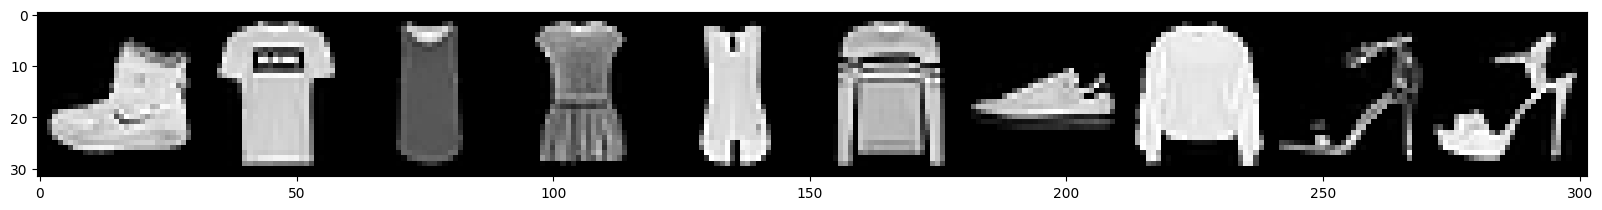

In [3]:
x = [train_dataset[i][0] for i in range(10)]
labels = [idx_to_class[train_dataset[i][1]] for i in range(10)]
print(labels)

plt.figure(figsize=(20,10))
show(torchvision.utils.make_grid(x, nrow=10))
plt.show()

## Model

In [4]:
# From Traning-Example Notebook
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

## Training

In [5]:
?F.nll_loss

Signature:
F.nll_loss(
    input: torch.Tensor,
    target: torch.Tensor,
    weight: Optional[torch.Tensor] = None,
    size_average: Optional[bool] = None,
    ignore_index: int = -100,
    reduce: Optional[bool] = None,
    reduction: str = 'mean',
) -> torch.Tensor
Docstring:
Compute the negative log likelihood loss.

See :class:`~torch.nn.NLLLoss` for details.

Args:
    input: :math:`(N, C)` where `C = number of classes` or :math:`(N, C, H, W)`
        in case of 2D Loss, or :math:`(N, C, d_1, d_2, ..., d_K)` where :math:`K \geq 1`
        in the case of K-dimensional loss. `input` is expected to be log-probabilities.
    target: :math:`(N)` where each value is :math:`0 \leq \text{targets}[i] \leq C-1`,
        or :math:`(N, d_1, d_2, ..., d_K)` where :math:`K \geq 1` for
        K-dimensional loss.
    weight (Tensor, optional): a manual rescaling weight given to each
        class. If given, has to be a Tensor of size `C`
    size_average (bool, optional): Deprecated (see :attr

In [44]:
def train(model, device, loader, optimizer, loss_fn, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(loader):
        data, target = data.to(device), target.to(device)

        # Debug:
        # print(target.shape)
        # print(data.shape)

        optimizer.zero_grad()
        output = model(data)
        # print(output.shape)
        loss = loss_fn(output, target)
        # print("Real class:", target.shape)
        # print("Predicted class:", output.argmax(dim=1, keepdim=True).squeeze())
        loss.backward()
        optimizer.step()
        
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(loader.dataset),
                100. * batch_idx / len(loader), loss.item()), end='\r')


def test(model, device, loader, loss_fn):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            # print(output.shape)
            test_loss += loss_fn(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(loader.dataset),
    100. * correct / len(loader.dataset)), end='\r')

In [7]:
model = Net()
model.to(device)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

In [8]:
?torch.optim.lr_scheduler.StepLR

Init signature:
torch.optim.lr_scheduler.StepLR(
    optimizer: torch.optim.optimizer.Optimizer,
    step_size: int,
    gamma: float = 0.1,
    last_epoch: int = -1,
)
Docstring:     
Decays the learning rate of each parameter group by gamma every step_size epochs.

Notice that such decay can happen simultaneously with other changes to the learning rate
from outside this scheduler. When last_epoch=-1, sets initial lr as lr.

Args:
    optimizer (Optimizer): Wrapped optimizer.
    step_size (int): Period of learning rate decay.
    gamma (float): Multiplicative factor of learning rate decay.
        Default: 0.1.
    last_epoch (int): The index of last epoch. Default: -1.

Example:
    >>> # xdoctest: +SKIP
    >>> # Assuming optimizer uses lr = 0.05 for all groups
    >>> # lr = 0.05     if epoch < 30
    >>> # lr = 0.005    if 30 <= epoch < 60
    >>> # lr = 0.0005   if 60 <= epoch < 90
    >>> # ...
    >>> scheduler = StepLR(optimizer, step_size=30, gamma=0.1)
    >>> for epoch in 

In [9]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
loss_fn = nn.CrossEntropyLoss(reduction='sum')

for epoch in range(1, 11):
    train(model, device, train_loader, optimizer, loss_fn, epoch)
    test(model, device, test_loader, loss_fn)
    scheduler.step()

Train Epoch: 1 [59520/60000 (99%)]	Loss: 21.935234
Test set: Average loss: 0.3416, Accuracy: 8765/10000 (88%)
Train Epoch: 2 [59520/60000 (99%)]	Loss: 31.433453
Test set: Average loss: 0.2882, Accuracy: 8941/10000 (89%)
Train Epoch: 3 [59520/60000 (99%)]	Loss: 13.083773
Test set: Average loss: 0.2759, Accuracy: 8981/10000 (90%)
Train Epoch: 4 [59520/60000 (99%)]	Loss: 17.827511
Test set: Average loss: 0.2556, Accuracy: 9071/10000 (91%)
Train Epoch: 5 [59520/60000 (99%)]	Loss: 19.322462
Test set: Average loss: 0.2396, Accuracy: 9140/10000 (91%)
Train Epoch: 6 [59520/60000 (99%)]	Loss: 9.1802906
Test set: Average loss: 0.2302, Accuracy: 9203/10000 (92%)
Train Epoch: 7 [59520/60000 (99%)]	Loss: 11.451619
Test set: Average loss: 0.2260, Accuracy: 9220/10000 (92%)
Train Epoch: 8 [59520/60000 (99%)]	Loss: 16.756477
Test set: Average loss: 0.2235, Accuracy: 9226/10000 (92%)
Train Epoch: 9 [59520/60000 (99%)]	Loss: 8.1036756
Test set: Average loss: 0.2218, Accuracy: 9218/10000 (92%)
Train Epoc

## Evaluation
    - compute confusion matrix
    - compute Accuracy, Precision, Recall and F1 using the maximum response
    - visualize Precision-Recall curve for different classes 
    - visualize example images with predicted classes

### Confusion Matrix in shape 10x10 foir each class

In [10]:
type(test_dataset)

torchvision.datasets.mnist.FashionMNIST

In [11]:
dir(torchvision.datasets.mnist.FashionMNIST)

['__add__',
 '__annotations__',
 '__class__',
 '__class_getitem__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__orig_bases__',
 '__parameters__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_check_exists',
 '_check_legacy_exist',
 '_format_transform_repr',
 '_is_protocol',
 '_load_data',
 '_load_legacy_data',
 '_repr_indent',
 'class_to_idx',
 'classes',
 'download',
 'extra_repr',
 'mirrors',
 'processed_folder',
 'raw_folder',
 'resources',
 'test_data',
 'test_file',
 'test_labels',
 'train_data',
 'train_labels',
 'training_file']

In [12]:
test_dataset.targets

tensor([9, 2, 1,  ..., 8, 1, 5])

Text(0, 0.5, 'True Label')

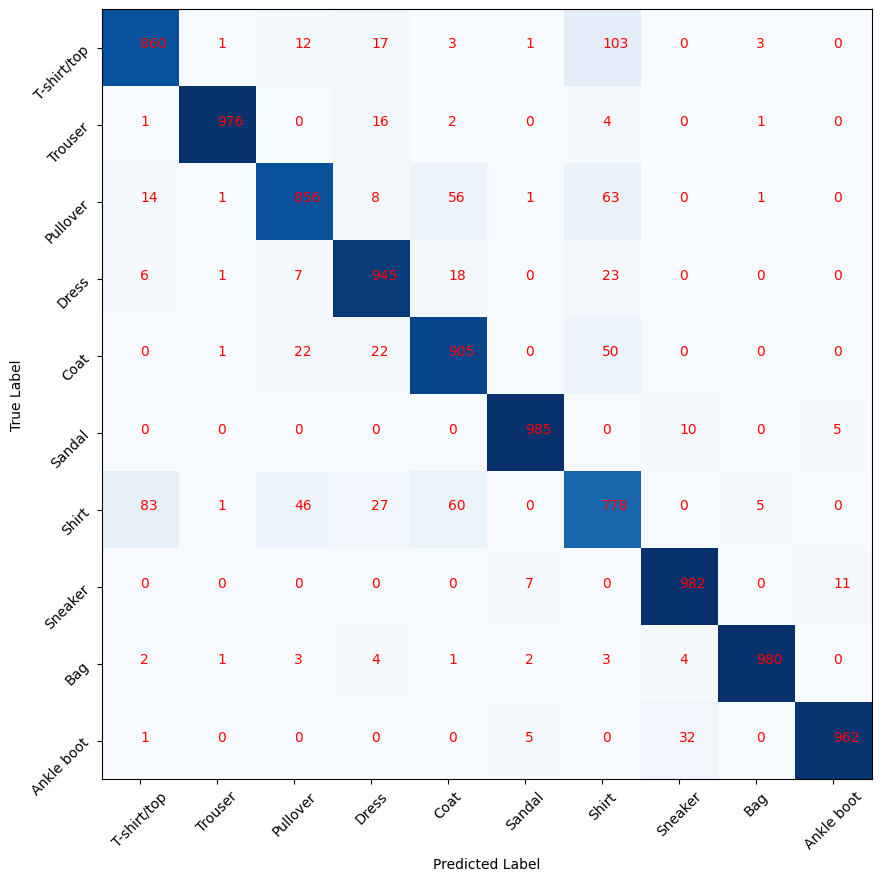

In [13]:
confusion_matrix = torch.zeros(10, 10)
# Y: True Label
# X: Predicted Label

model.eval()
# Iterate over all images in test_set
for data, target in test_dataset:
    data = data.to(device)
    # print(data.shape)
    output = model(data.unsqueeze(0))
    pred = output.argmax(dim=1, keepdim=True)
    # print(f"target: {target} has prediction {pred}")
    confusion_matrix[target][pred.to("cpu")] += 1

# Plot matrix
plt.figure(figsize=(10,10))
plt.xticks(range(10), [idx_to_class[i] for i in range(10)], rotation=45)
plt.yticks(range(10), [idx_to_class[i] for i in range(10)], rotation=45)
for i in range(10):
    for j in range(10):
        plt.text(j,i, int(confusion_matrix[i][j]), color="red")

plt.imshow(confusion_matrix, cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

## Accuracy, Precision, Recall and F1 using the maximum response

In [14]:
true_positive = torch.zeros(10)     # TP
true_negative = torch.zeros(10)     # TN
false_positive = torch.zeros(10)    # FP
false_negative = torch.zeros(10)    # FN 

model.eval()
model.to(device)
for data, target in test_dataset:
    data = data.to(device)
    out = model(data.unsqueeze(0))
    pred = out.argmax(dim=1, keepdims= True)
    if pred == target:
        true_positive[target] += 1          # TP
        # True Negatives
        for i in range(10):
            if i != target:
                true_negative[i] += 1       # TN
    else:
        false_negative[target] += 1         # FN
        false_positive[pred.to("cpu")] += 1 # FP

# Accuracy: correct classifications/total classifications   OR  (TP+TN)/(TP+TN+FP+FN) 
accuracy_matrix = (true_positive + true_negative) / (true_positive + true_negative + false_positive + false_negative)

# Precision:  correct actual positives/ everthing classified as positive:  TP/(TP+FP)
precision_matrix = true_positive/(true_positive + false_positive)

# Recall: correct actual positives/ all actual positives : TP/(TP+FN)
recall_matric = true_positive/(true_positive + false_negative)

# F1 Score: 2* (Precision*Recall)/(Precision+Recall)   OR  # 2*TP/(2*TP + FP + FN)
f1_matrix = 2 * true_positive / (2*true_positive + false_positive + false_negative)
f1_matrix_2 = 2* (precision_matrix * recall_matric) / (precision_matrix + recall_matric)

for i in range(10):
    print(idx_to_class[i])
    print(f"  Accuracy for: {round(float(accuracy_matrix[i]*100), 2)}%")
    print(f"  Precision for: {round(float(precision_matrix[i]*100), 2)}%")
    print(f"  Recall for: {round(float(recall_matric[i]*100), 2)}%")
    print(f"  F1 Score: {round(float(f1_matrix[i]*100), 2)}%\n")
    # print(f"F1 Score : {f1_matrix_2[i]}%")

T-shirt/top
  Accuracy for: 97.39%
  Precision for: 88.93%
  Recall for: 86.0%
  F1 Score: 87.44%

Trouser
  Accuracy for: 99.68%
  Precision for: 99.39%
  Recall for: 97.6%
  F1 Score: 98.49%

Pullover
  Accuracy for: 97.53%
  Precision for: 90.49%
  Recall for: 85.6%
  F1 Score: 87.98%

Dress
  Accuracy for: 98.41%
  Precision for: 90.95%
  Recall for: 94.5%
  F1 Score: 92.69%

Coat
  Accuracy for: 97.52%
  Precision for: 86.6%
  Recall for: 90.5%
  F1 Score: 88.51%

Sandal
  Accuracy for: 99.67%
  Precision for: 98.4%
  Recall for: 98.5%
  F1 Score: 98.45%

Shirt
  Accuracy for: 95.17%
  Precision for: 75.98%
  Recall for: 77.8%
  F1 Score: 76.88%

Sneaker
  Accuracy for: 99.31%
  Precision for: 95.53%
  Recall for: 98.2%
  F1 Score: 96.84%

Bag
  Accuracy for: 99.68%
  Precision for: 98.99%
  Recall for: 98.0%
  F1 Score: 98.49%

Ankle boot
  Accuracy for: 99.42%
  Precision for: 98.36%
  Recall for: 96.2%
  F1 Score: 97.27%



## visualize Precision-Recall curve for different classes 

In [15]:
?precision_recall_curve

Signature:
precision_recall_curve(
    y_true,
    y_score,
    *,
    pos_label=None,
    sample_weight=None,
    drop_intermediate=False,
)
Docstring:
Compute precision-recall pairs for different probability thresholds.

Note: this implementation is restricted to the binary classification task.

The precision is the ratio ``tp / (tp + fp)`` where ``tp`` is the number of
true positives and ``fp`` the number of false positives. The precision is
intuitively the ability of the classifier not to label as positive a sample
that is negative.

The recall is the ratio ``tp / (tp + fn)`` where ``tp`` is the number of
true positives and ``fn`` the number of false negatives. The recall is
intuitively the ability of the classifier to find all the positive samples.

The last precision and recall values are 1. and 0. respectively and do not
have a corresponding threshold. This ensures that the graph starts on the
y axis.

The first precision and recall values are precision=class balance and recall=

Text(0.5, 1.0, "Precision-Recall Curve for classes: ['T-shirt/top', 'Dress', 'Sandal', 'Bag']")

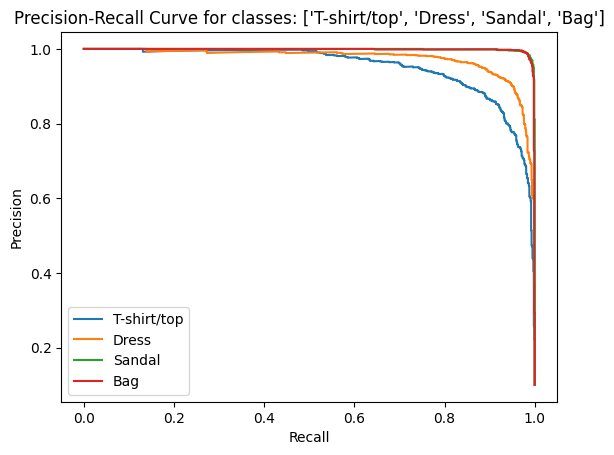

In [16]:
indices = [0,3,5,8]

for i in indices:
    y_true = (test_dataset.targets == i)
    y_scores = []

    model.eval()
    for data, target in test_dataset:
        data = data.to(device)
        out = model(data.unsqueeze(0))
        i_score = out[0][i].item()
        # print(i_score)
        y_scores.append(i_score)
    
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    plt.plot(recall, precision, label=f"{idx_to_class[i]}")

plt.legend()
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Precision-Recall Curve for classes: {[idx_to_class[i] for i in indices]}")

## visualize example images with predicted classes

(0, 0, 0, 0, 0)


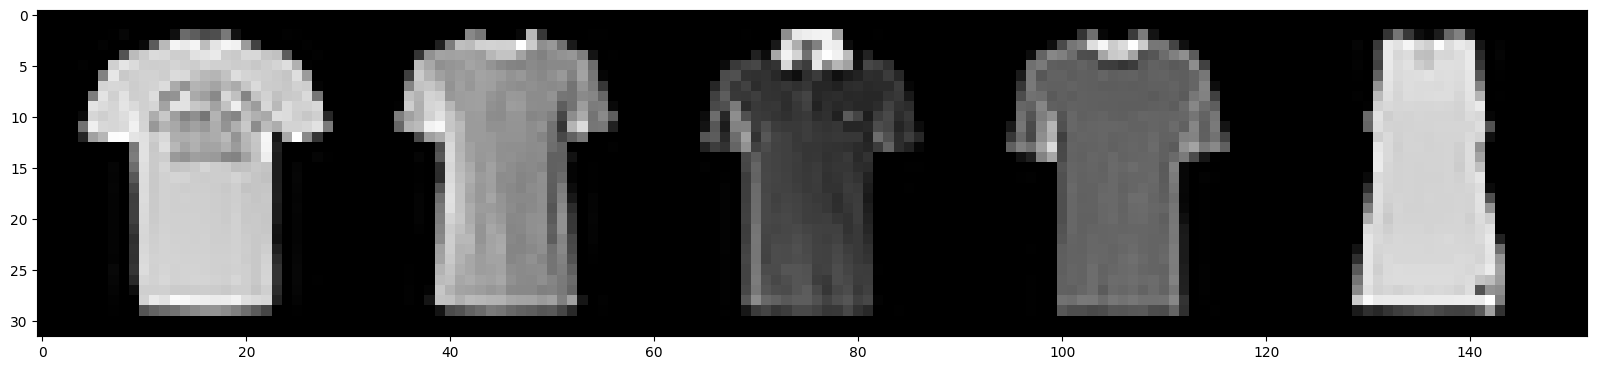

In [17]:
import random 

def visualize_examples(class_idx, amount, dataset = test_dataset):
    predictions = []
    for data, target in test_dataset:
        data = data.to(device)
        out = model(data.unsqueeze(0))
        pred = out.argmax(dim=1, keepdim=True)
        predictions.append(pred.item())

    # Indices with same class
    random_indices = torch.where(torch.tensor(predictions) == class_idx)[0].tolist()
    indices = random.sample(random_indices, amount)

    # From "Training-Example.ipynb"
    x,y = zip(*[dataset[i] for i in indices])
    x = torch.stack(x)

    grid_img = torchvision.utils.make_grid(x, nrow=amount)
    plt.figure(figsize=(20,5))
    plt.imshow(grid_img.permute(1, 2, 0))
    print(y)

visualize_examples(class_idx = 0, amount = 5)

# Task 2: Image Denoising
1. define a Neural Network
2. define optimization procedure on NoisyFashionMNIST
3. train denoising model
4. Evaluate model

## Dataset
Random augmentations are added to the original dataset.

In [18]:
train_dataset_noisy = NoisyFashionMNIST("./data", True)
test_dataset_noisy = NoisyFashionMNIST("./data", False)

In [19]:
test_loader_noisy = torch.utils.data.DataLoader(test_dataset_noisy, batch_size=64, shuffle=False)

In [20]:
train_dataset_noisy.dataset

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.39670697..1.3022405].


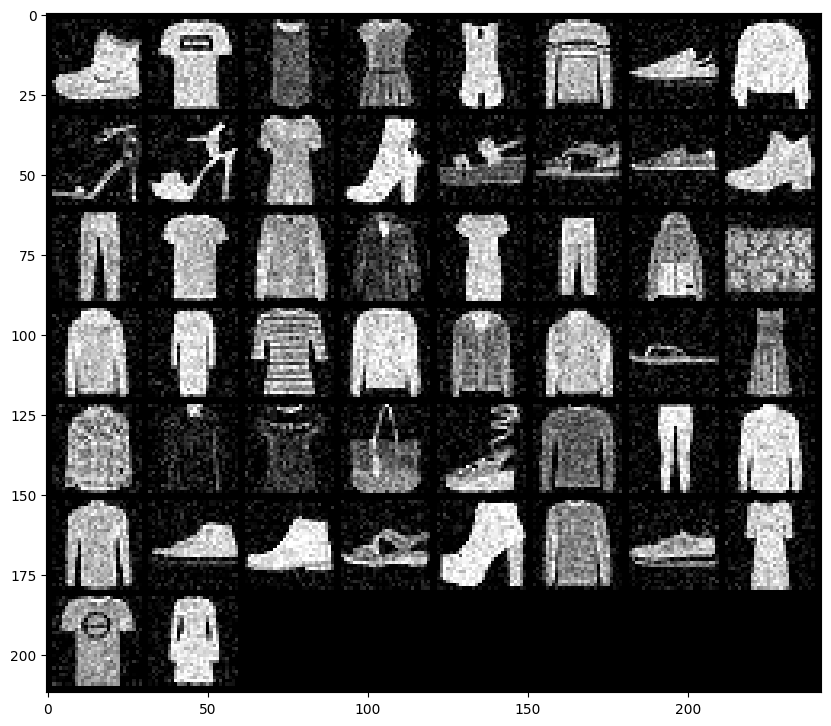

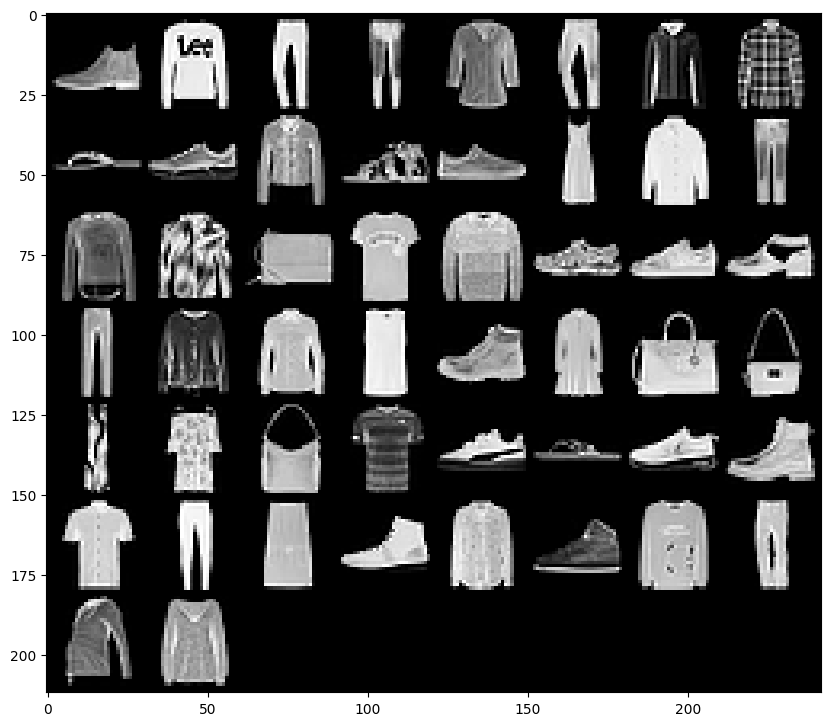

In [21]:
x = [train_dataset_noisy[i][0] for i in range(50)]
y = [test_dataset_noisy[i][1] for i in range(50)]

plt.figure(figsize=(10,10))
show(torchvision.utils.make_grid(x))
plt.show()

plt.figure(figsize=(10,10))
show(torchvision.utils.make_grid(y))
plt.show()

## Classifier

### Model

In [22]:
model_noisy = Net()
model_noisy.to(device)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

### Train

There is a problem with the `NoisyFashionMNIST` dataset from `utils.py`. It never returns the correct labels but instead `noisy_img, img`. Therefore a new combined dataset is introducted for training which combines the noisy images with the labels.

In [23]:
from torch.utils.data import Dataset

class NoisyWithLabels(Dataset):
    def __init__(self, noisy_dataset):
        self.noisy = noisy_dataset
        self.clean = noisy_dataset.dataset

    def __len__(self):
        return len(self.noisy)

    def __getitem__(self, idx):
        noisy_img, original_img = self.noisy[idx]  
        label = self.clean[idx][1]                   # int label from FashionMNIST
        return torch.tensor(noisy_img), torch.tensor(label)

wrapped_train = NoisyWithLabels(train_dataset_noisy)
wrapped_test  = NoisyWithLabels(test_dataset_noisy)

wrapped_train_loader = torch.utils.data.DataLoader(wrapped_train, batch_size=64, shuffle=True)
wrapped_test_loader  = torch.utils.data.DataLoader(wrapped_test,  batch_size=64, shuffle=False)

# Print first 10 of dataset
x = [wrapped_train[i][0] for i in range(10)]
labels = [wrapped_train[i][1] for i in range(10)]
print(labels)

# get from real dataset first 10
x_clean = [train_dataset[i][0] for i in range(10)]
labels_clean = [train_dataset[i][1] for i in range(10)]
print(labels_clean)

[tensor(9), tensor(0), tensor(0), tensor(3), tensor(0), tensor(2), tensor(7), tensor(2), tensor(5), tensor(5)]
[9, 0, 0, 3, 0, 2, 7, 2, 5, 5]


C:\Users\Jean\AppData\Local\Temp\ipykernel_12712\358494295.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(noisy_img), torch.tensor(label)


In [24]:
print("Normal FashionMNIST:")
for data, target in test_loader:
    print(f"Data shape: {data.shape}") 
    print(f"Target shape: {target.shape}")  
    break

print("\nNoisyFashionMNIST:")
for noisy_data, original_data in test_loader_noisy:
    print(f"Noisy Data shape: {noisy_data.shape}") 
    print(f"Original Data shape: {original_data.shape}")
    break

Normal FashionMNIST:
Data shape: torch.Size([64, 1, 28, 28])
Target shape: torch.Size([64])

NoisyFashionMNIST:
Noisy Data shape: torch.Size([64, 1, 28, 28])
Original Data shape: torch.Size([64, 1, 28, 28])


In [25]:
model_noisy = Net().to(device)

In [26]:
optimizer = torch.optim.Adam(model_noisy.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
loss_fn = nn.CrossEntropyLoss(reduction='sum')

for epoch in range(1, 11):
    train(model_noisy, device, wrapped_train_loader, optimizer, loss_fn, epoch)
    test(model_noisy, device, wrapped_test_loader, loss_fn)
    scheduler.step()

C:\Users\Jean\AppData\Local\Temp\ipykernel_12712\358494295.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(noisy_img), torch.tensor(label)


Train Epoch: 1 [59520/60000 (99%)]	Loss: 29.222767
Test set: Average loss: 0.3693, Accuracy: 8664/10000 (87%)
Train Epoch: 2 [59520/60000 (99%)]	Loss: 21.623266
Test set: Average loss: 0.3279, Accuracy: 8799/10000 (88%)
Train Epoch: 3 [59520/60000 (99%)]	Loss: 12.766674
Test set: Average loss: 0.2971, Accuracy: 8883/10000 (89%)
Train Epoch: 4 [59520/60000 (99%)]	Loss: 18.426634
Test set: Average loss: 0.2915, Accuracy: 8920/10000 (89%)
Train Epoch: 5 [59520/60000 (99%)]	Loss: 21.691500
Test set: Average loss: 0.2779, Accuracy: 8988/10000 (90%)
Train Epoch: 6 [59520/60000 (99%)]	Loss: 10.870441
Test set: Average loss: 0.2690, Accuracy: 9035/10000 (90%)
Train Epoch: 7 [59520/60000 (99%)]	Loss: 13.817049
Test set: Average loss: 0.2606, Accuracy: 9066/10000 (91%)
Train Epoch: 8 [59520/60000 (99%)]	Loss: 16.728907
Test set: Average loss: 0.2605, Accuracy: 9075/10000 (91%)
Train Epoch: 9 [59520/60000 (99%)]	Loss: 10.587058
Test set: Average loss: 0.2559, Accuracy: 9075/10000 (91%)
Train Epoc

## Denoising Model

### Model

In [27]:
class DenoisingNet(nn.Module):
    def __init__(self):
        super(DenoisingNet, self).__init__()
        # Encoder (Down)
        self.conv1 = nn.Conv2d(1, 32, 3, 1, padding=1)  # Output: [32, 28, 28]
        self.conv2 = nn.Conv2d(32, 64, 3, 1, padding=1)  # Output: [64, 28, 28]

        # Decoder (Up)
        self.deconv1 = nn.ConvTranspose2d(64, 32, 2, stride=2)  # Output: [32, 28, 28]
        self.deconv2 = nn.ConvTranspose2d(32, 1, 3, stride=1, padding=1)  # Output: [1, 28, 28]

    def forward(self, x):
        # Encoder
        x = self.conv1(x)
        # print(f"After conv1: {x.shape}")
        x = F.relu(x)
        x = self.conv2(x)
        # print(f"After conv2: {x.shape}")
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        # print(f"After max_pool2d: {x.shape}")
        # x = self.dropout1(x)

        # Decoder
        x = self.deconv1(x)
        # print(f"After deconv1: {x.shape}")
        x = F.relu(x)
        x = self.deconv2(x)
        # print(f"After deconv2: {x.shape}")
        output = torch.sigmoid(x)  # For pixel values in [0, 1]
        return output

In [28]:
dummy_input = torch.randn(1, 1, 28, 28)
denoising_test = DenoisingNet().to(device)
denoising_test(dummy_input.to(device))

tensor([[[[0.4095, 0.4595, 0.3978, 0.4733, 0.4394, 0.4685, 0.4473, 0.5033,
           0.4349, 0.5087, 0.3892, 0.4719, 0.4200, 0.5017, 0.4524, 0.4901,
           0.4199, 0.4772, 0.4524, 0.4739, 0.4375, 0.4888, 0.4159, 0.4722,
           0.4234, 0.4941, 0.4306, 0.4726],
          [0.4853, 0.4115, 0.4243, 0.4129, 0.4280, 0.4260, 0.4577, 0.4200,
           0.4968, 0.4313, 0.4287, 0.3848, 0.4132, 0.4260, 0.4289, 0.4408,
           0.4492, 0.4290, 0.4587, 0.4279, 0.4720, 0.4063, 0.4607, 0.4394,
           0.5154, 0.3763, 0.3873, 0.4229],
          [0.4253, 0.4670, 0.4372, 0.4907, 0.4192, 0.4542, 0.4035, 0.4338,
           0.4238, 0.4897, 0.4063, 0.4400, 0.3382, 0.4332, 0.4442, 0.4765,
           0.4038, 0.4636, 0.4136, 0.4748, 0.4478, 0.4908, 0.4049, 0.4696,
           0.4308, 0.4430, 0.4270, 0.4887],
          [0.5053, 0.4038, 0.4482, 0.4036, 0.4437, 0.4351, 0.4395, 0.3793,
           0.4324, 0.3861, 0.4204, 0.3743, 0.3986, 0.3762, 0.4226, 0.4027,
           0.4388, 0.4552, 0.4424, 0.3722, 

### Training

In [29]:
train_loader_denoise = torch.utils.data.DataLoader(train_dataset_noisy, batch_size=64, shuffle=True)
test_loader_denoise = torch.utils.data.DataLoader(test_dataset_noisy, batch_size=64, shuffle=False)

In [31]:
model_denoise = DenoisingNet().to(device)
optimizer = torch.optim.Adam(model_denoise.parameters(), lr=0.001)
loss_fn = nn.MSELoss(reduction='sum')

for epoch in range(1, 11):
    train(model_denoise, device, train_loader_denoise, optimizer, loss_fn, epoch)
    print("\n")
    # test(model_denoise, device, test_loader_denoise, loss_fn)

Train Epoch: 1 [59520/60000 (99%)]	Loss: 152.300873

Train Epoch: 2 [59520/60000 (99%)]	Loss: 131.835297

Train Epoch: 3 [59520/60000 (99%)]	Loss: 110.453430

Train Epoch: 4 [59520/60000 (99%)]	Loss: 116.046928

Train Epoch: 5 [59520/60000 (99%)]	Loss: 117.729866

Train Epoch: 6 [59520/60000 (99%)]	Loss: 113.196381

Train Epoch: 7 [59520/60000 (99%)]	Loss: 124.999878

Train Epoch: 8 [59520/60000 (99%)]	Loss: 108.384392

Train Epoch: 9 [59520/60000 (99%)]	Loss: 111.669319

Train Epoch: 10 [59520/60000 (99%)]	Loss: 123.683228



In [32]:
def visualize_denoising_examples(amount, model, dataset=train_dataset_noisy):
    indices = random.sample(range(len(dataset)), amount)

    noisy_images, original_images = zip(*[dataset[idx] for idx in indices])
    with torch.no_grad():
        denoised_images = [model(noisy_img.unsqueeze(0).to(device)) for noisy_img in noisy_images]

    # Plot the images
    plt.figure(figsize=(20, 10))
    for i in range(amount):
        # Original images (row 1)
        plt.subplot(3, amount, i + 1)
        plt.imshow(original_images[i].squeeze(), cmap="gray")
        plt.axis("off")
        if i == 0:
            plt.ylabel("Original", fontsize=14)

        # Noisy images (row 2)
        plt.subplot(3, amount, amount + i + 1)
        plt.imshow(noisy_images[i].squeeze(), cmap="gray")
        plt.axis("off")
        if i == 0:
            plt.ylabel("Noisy", fontsize=14)

        # Denoised images (row 3)
        plt.subplot(3, amount, 2 * amount + i + 1)
        plt.imshow(denoised_images[i].squeeze().to("cpu"), cmap="gray")
        plt.axis("off")
        if i == 0:
            plt.ylabel("Denoised", fontsize=14)

    plt.tight_layout()
    plt.show()

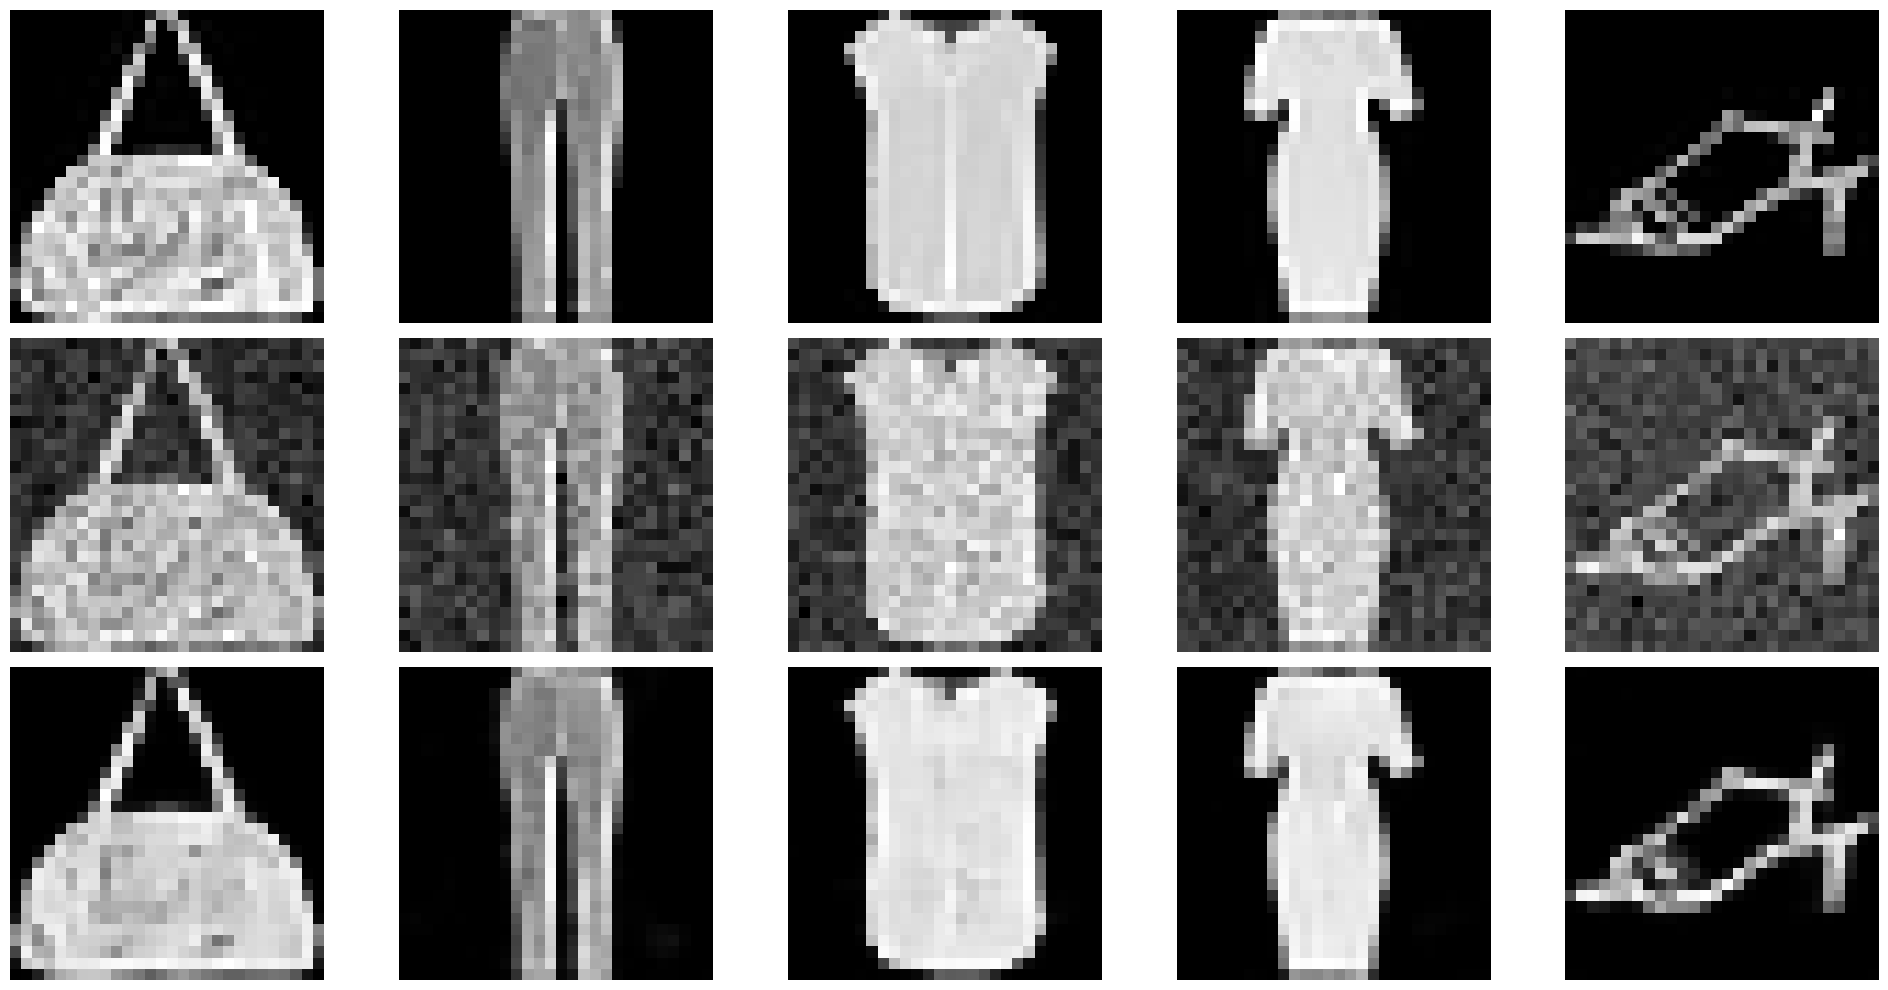

In [33]:
visualize_denoising_examples(amount=5, model=model_denoise, dataset=train_dataset_noisy)

# Task 3: Model Selection

Conduct at least **3 experiments** for **each** of the previous tasks and document them (i.e. at least 6 experiments).  
Evaluate the effect of different parameters on the classification and denoising tasks.  
Conduct the following experiments:
- Evaluate the effect of residual connections
- Evaluate the effect of the depth(number of layers)/width (number of channels or number of neurons) of the network  
- Evaluate the effect of Batch normalization

## Optional experiments:
- How does the loss function affect denoising? Alternative loss functions: MSE, MAE, SSIM?
- How does Dropout affect the performance?
- Use different downsampling/upsampling layers, e.g.pooling, strided convolution, transposed convolution, etc.  
- Feel free to explore more variations of your model and training.

In [76]:
train_loader_classification = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader_classification = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)


## Experiment 1: Residual Connections (Skip Conn)

In [114]:
class skipcon(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(skipcon, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1) # padding requried else dim mismatch
         
        # match dimensions if stride or channels change
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            print(f"Shortcut with stride {stride} and in_channels {in_channels} != out_channels {out_channels}")
            self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride)

    def forward(self, x):
        skipped = self.shortcut(x) # 'x' in F(x) + x

        out = self.conv(x)
        
        out += skipped
        return out
    
class skipcon_alt(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(skipcon_alt, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1) # padding requried else dim mismatch
         
        # match dimensions if stride or channels change
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            print(f"Shortcut with stride {stride} and in_channels {in_channels} != out_channels {out_channels}")
            self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride)

    def forward(self, x):
        skipped = self.shortcut(x) # 'x' in F(x) + x

        out = self.conv(x)
        
        # out += skipped
        return out

### For the Classification Model 
It makes most sense to place residual connections around `conv1` and `conv2`.

In [85]:
class NetWithResidual(nn.Module):
    def __init__(self):
        super(NetWithResidual, self).__init__()
        self.skipcon1 = skipcon(in_channels=1, out_channels=32, stride=1)
        self.skipcon2 = skipcon(in_channels=32, out_channels=64, stride=1)
        
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        
        self.fc1 = nn.Linear(12544, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.skipcon1(x)
        x = F.relu(x)
        x = self.skipcon2(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [86]:
model_skipconn = NetWithResidual().to(device)

Shortcut with stride 1 and in_channels 1 != out_channels 32
Shortcut with stride 1 and in_channels 32 != out_channels 64


In [79]:
dummy_input = torch.randn(1, 1, 28, 28)

print(model(dummy_input.to(device)).shape)
print(model_skipconn(dummy_input.to(device)).shape)

torch.Size([1, 10])
torch.Size([1, 10])


In [98]:
optimizer_skipconn = torch.optim.Adam(model_skipconn.parameters(), lr=0.001)
scheduler_skipconn = torch.optim.lr_scheduler.StepLR(optimizer_skipconn, step_size=5, gamma=0.1)
loss_fn_classification = nn.CrossEntropyLoss(reduction='sum')

for epoch in range(1, 11):
    train(model_skipconn, device, train_loader_classification, optimizer_skipconn, loss_fn_classification, epoch)
    test(model_skipconn, device, test_loader_classification, loss_fn_classification)
    scheduler_skipconn.step()

Train Epoch: 1 [59520/60000 (99%)]	Loss: 27.557068
Test set: Average loss: 0.3332, Accuracy: 8757/10000 (88%)
Train Epoch: 2 [59520/60000 (99%)]	Loss: 30.899019
Test set: Average loss: 0.2821, Accuracy: 8950/10000 (90%)
Train Epoch: 3 [59520/60000 (99%)]	Loss: 15.695721
Test set: Average loss: 0.2607, Accuracy: 9032/10000 (90%)
Train Epoch: 4 [59520/60000 (99%)]	Loss: 20.318848
Test set: Average loss: 0.2521, Accuracy: 9091/10000 (91%)
Train Epoch: 5 [59520/60000 (99%)]	Loss: 12.510921
Test set: Average loss: 0.2472, Accuracy: 9109/10000 (91%)
Train Epoch: 6 [59520/60000 (99%)]	Loss: 20.864254
Test set: Average loss: 0.2229, Accuracy: 9202/10000 (92%)
Train Epoch: 7 [59520/60000 (99%)]	Loss: 12.188889
Test set: Average loss: 0.2228, Accuracy: 9211/10000 (92%)
Train Epoch: 8 [59520/60000 (99%)]	Loss: 7.4898948
Test set: Average loss: 0.2206, Accuracy: 9215/10000 (92%)
Train Epoch: 9 [59520/60000 (99%)]	Loss: 11.574743
Test set: Average loss: 0.2206, Accuracy: 9220/10000 (92%)
Train Epoc

In [148]:
true_positive = torch.zeros(10)     # TP
true_negative = torch.zeros(10)     # TN
false_positive = torch.zeros(10)    # FP
false_negative = torch.zeros(10)    # FN 

model_skipconn.eval()
model_skipconn.to(device)
for data, target in test_dataset:
    data = data.to(device)
    out = model_skipconn(data.unsqueeze(0))
    pred = out.argmax(dim=1, keepdims= True)
    if pred == target:
        true_positive[target] += 1          # TP
        # True Negatives
        for i in range(10):
            if i != target:
                true_negative[i] += 1       # TN
    else:
        false_negative[target] += 1         # FN
        false_positive[pred.to("cpu")] += 1 # FP

# Accuracy: correct classifications/total classifications   OR  (TP+TN)/(TP+TN+FP+FN) 
accuracy_matrix_skipconn = (true_positive + true_negative) / (true_positive + true_negative + false_positive + false_negative)

# Precision:  correct actual positives/ everthing classified as positive:  TP/(TP+FP)
precision_matrix_skipconn = true_positive/(true_positive + false_positive)

# Recall: correct actual positives/ all actual positives : TP/(TP+FN)
recall_matric_skipconn = true_positive/(true_positive + false_negative)

# F1 Score: 2* (Precision*Recall)/(Precision+Recall)   OR  # 2*TP/(2*TP + FP + FN)
f1_matrix_skipconn = 2 * true_positive / (2*true_positive + false_positive + false_negative)
f1_matrix_2_skipconn = 2* (precision_matrix_skipconn * recall_matric_skipconn) / (precision_matrix_skipconn + recall_matric_skipconn)

for i in range(10):
    print(idx_to_class[i])
    print(f"  Accuracy for: {round(float(accuracy_matrix_skipconn[i]*100), 2)}%")
    print(f"  Precision for: {round(float(precision_matrix_skipconn[i]*100), 2)}%")
    print(f"  Recall for: {round(float(recall_matric_skipconn[i]*100), 2)}%")
    print(f"  F1 Score: {round(float(f1_matrix_skipconn[i]*100), 2)}%\n")
    # print(f"F1 Score : {f1_matrix_2[i]}%")

T-shirt/top
  Accuracy for: 97.34%
  Precision for: 87.55%
  Recall for: 87.2%
  F1 Score: 87.37%

Trouser
  Accuracy for: 99.71%
  Precision for: 99.69%
  Recall for: 97.6%
  F1 Score: 98.64%

Pullover
  Accuracy for: 97.36%
  Precision for: 87.2%
  Recall for: 87.9%
  F1 Score: 87.55%

Dress
  Accuracy for: 98.21%
  Precision for: 89.92%
  Recall for: 93.7%
  F1 Score: 91.77%

Coat
  Accuracy for: 97.42%
  Precision for: 87.43%
  Recall for: 88.3%
  F1 Score: 87.86%

Sandal
  Accuracy for: 99.69%
  Precision for: 98.79%
  Recall for: 98.3%
  F1 Score: 98.55%

Shirt
  Accuracy for: 95.21%
  Precision for: 77.77%
  Recall for: 75.2%
  F1 Score: 76.46%

Sneaker
  Accuracy for: 99.33%
  Precision for: 95.8%
  Recall for: 98.1%
  F1 Score: 96.94%

Bag
  Accuracy for: 99.68%
  Precision for: 98.89%
  Recall for: 98.1%
  F1 Score: 98.49%

Ankle boot
  Accuracy for: 99.43%
  Precision for: 97.97%
  Recall for: 96.7%
  F1 Score: 97.33%



### For the Denoising Model

In [125]:
class DenoisingNetWithResidual(nn.Module):
    def __init__(self):
        super(DenoisingNetWithResidual, self).__init__()
        # Encoder (Down)
        self.skipcon1 = skipcon(in_channels=1, out_channels=32, stride=1)  # Output: [32, 28, 28]
        self.skipcon2 = skipcon(32, 64, stride=1)   # Output: [64, 28, 28]

        # Decoder (Up)
        self.deconv1 = nn.ConvTranspose2d(64, 32, 2, stride=2)  # Output: [32, 28, 28]
        self.deconv2 = nn.ConvTranspose2d(32, 1, 3, stride=1, padding=1)  # Output: [1, 28, 28]

    def forward(self, x):
        # Encoder
        x = self.skipcon1(x)
        # print(f"After conv1: {x.shape}")
        x = F.relu(x)
        x = self.skipcon2(x)
        # print(f"After conv2: {x.shape}")
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        # print(f"After max_pool2d: {x.shape}")
        # x = self.dropout1(x)

        # Decoder
        x = self.deconv1(x)
        # print(f"After deconv1: {x.shape}")
        x = F.relu(x)
        x = self.deconv2(x)
        # print(f"After deconv2: {x.shape}")
        output = torch.sigmoid(x)  # For pixel values in [0, 1]
        return output

In [127]:
dummy_input_denoise = torch.randn(1, 1, 28, 28)
# Create an instance of the new model
denoising_model_res = DenoisingNetWithResidual()
print( denoising_model_res(dummy_input_denoise).shape)

Shortcut with stride 1 and in_channels 1 != out_channels 32
Shortcut with stride 1 and in_channels 32 != out_channels 64
torch.Size([1, 1, 28, 28])


In [130]:
model_denoise_skipcon = DenoisingNetWithResidual().to(device)
optimizer_skipconn = torch.optim.Adam(model_denoise_skipcon.parameters(), lr=0.001)
loss_fn_denoise = nn.MSELoss(reduction='sum')

for epoch in range(1, 11):
    train(model_denoise_skipcon, device, train_loader_denoise, optimizer_skipconn, loss_fn, epoch)
    print("\n")
    # test(model_denoise, device, test_loader_denoise, loss_fn)

Shortcut with stride 1 and in_channels 1 != out_channels 32
Shortcut with stride 1 and in_channels 32 != out_channels 64
Train Epoch: 1 [59520/60000 (99%)]	Loss: 152.368698

Train Epoch: 2 [59520/60000 (99%)]	Loss: 134.831024

Train Epoch: 3 [59520/60000 (99%)]	Loss: 128.384705

Train Epoch: 4 [59520/60000 (99%)]	Loss: 122.812988

Train Epoch: 5 [59520/60000 (99%)]	Loss: 121.320946

Train Epoch: 6 [59520/60000 (99%)]	Loss: 123.652451

Train Epoch: 7 [59520/60000 (99%)]	Loss: 126.477448

Train Epoch: 8 [59520/60000 (99%)]	Loss: 112.247681

Train Epoch: 9 [59520/60000 (99%)]	Loss: 122.467735

Train Epoch: 10 [59520/60000 (99%)]	Loss: 126.499397



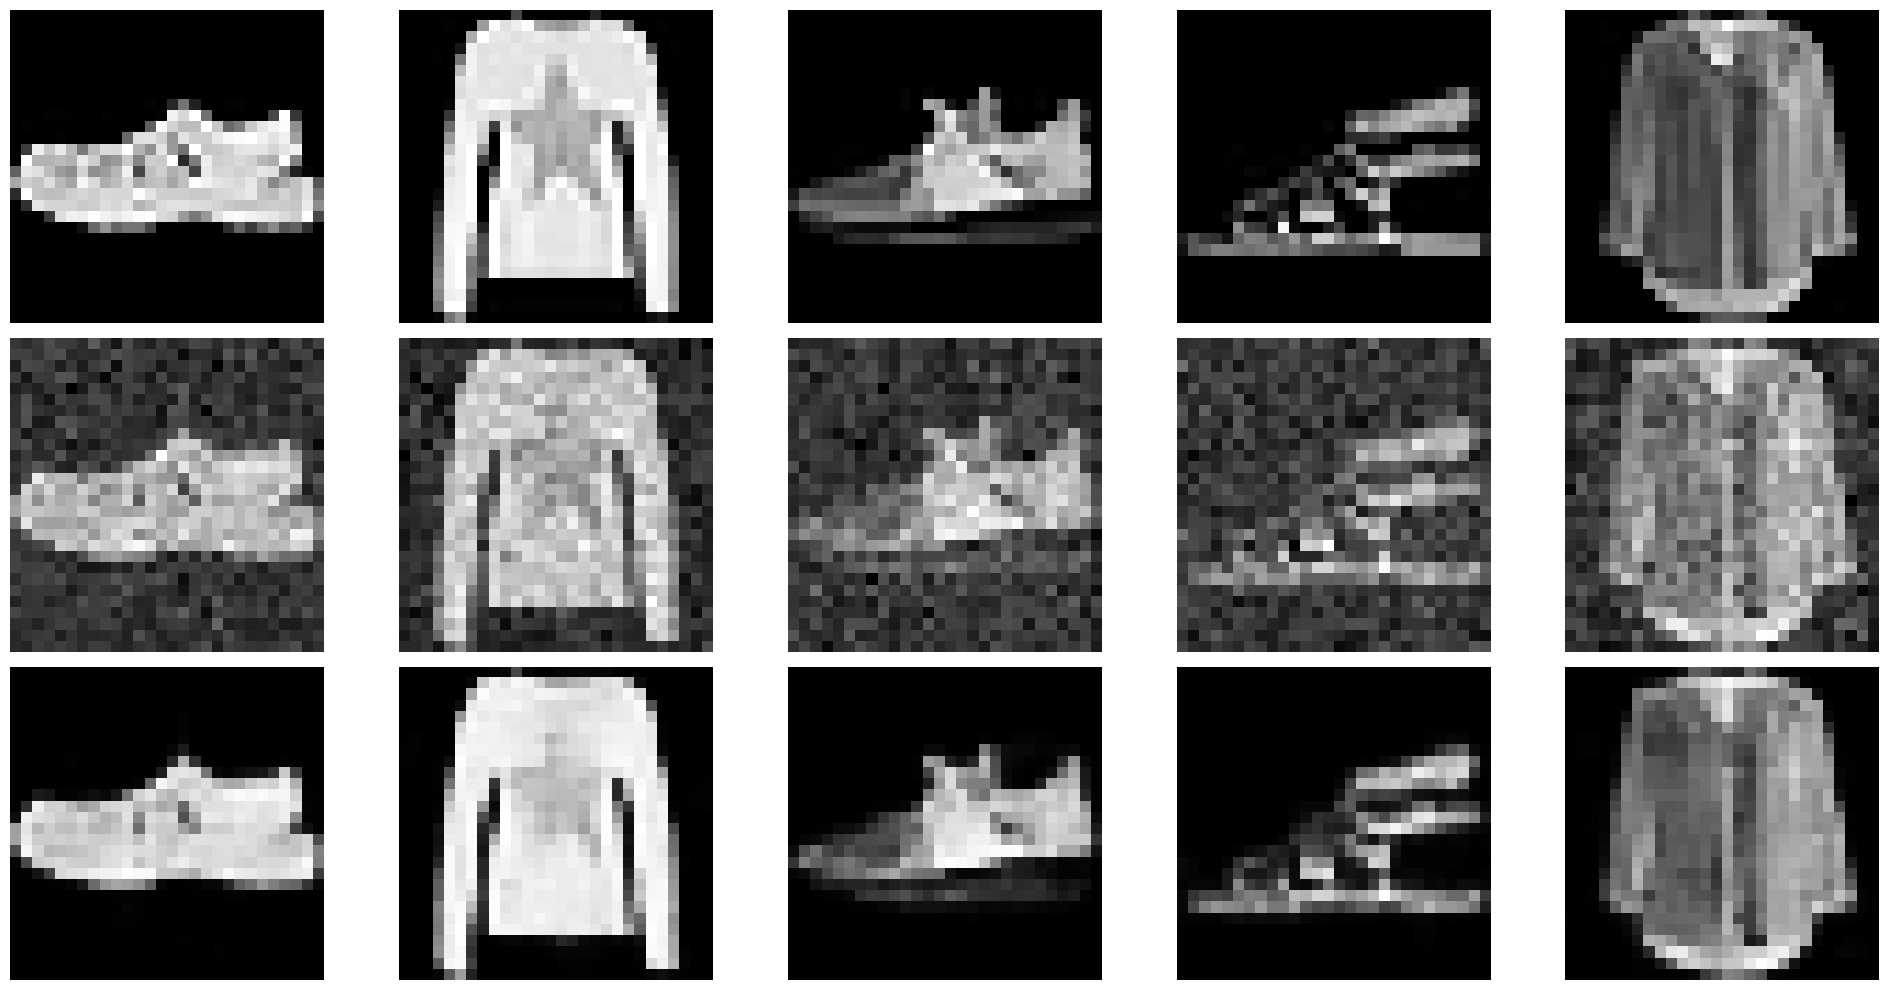

In [131]:
visualize_denoising_examples(amount=5, model=model_denoise_skipcon, dataset=train_dataset_noisy)

### Observation
Scores and visuall the results are very similar with no significant improvement. This could be due to the fact that the reference model is very shallow.

## Experiment 2: Depth

### For Classification Model

In [141]:
class Net_Deeper(nn.Module):
    def __init__(self):
        super(Net_Deeper, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.conv3 = nn.Conv2d(64, 128, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(128 * 11 * 11, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [144]:
model_deeper = Net_Deeper().to(device)
optimizer_deeper = torch.optim.Adam(model_deeper.parameters(), lr=0.001)
scheduler_deeper = torch.optim.lr_scheduler.StepLR(optimizer_deeper, step_size=5, gamma=0.1)

for epoch in range(1, 11):
    train(model_deeper, device, train_loader_classification, optimizer_deeper, loss_fn_classification, epoch)
    test(model_deeper, device, test_loader_classification, loss_fn_classification)
    scheduler_deeper.step()

Train Epoch: 1 [59520/60000 (99%)]	Loss: 27.351063
Test set: Average loss: 0.3374, Accuracy: 8780/10000 (88%)
Train Epoch: 2 [59520/60000 (99%)]	Loss: 14.900571
Test set: Average loss: 0.2795, Accuracy: 8993/10000 (90%)
Train Epoch: 3 [59520/60000 (99%)]	Loss: 16.310072
Test set: Average loss: 0.2621, Accuracy: 9069/10000 (91%)
Train Epoch: 4 [59520/60000 (99%)]	Loss: 12.507044
Test set: Average loss: 0.2339, Accuracy: 9130/10000 (91%)
Train Epoch: 5 [59520/60000 (99%)]	Loss: 13.584384
Test set: Average loss: 0.2261, Accuracy: 9197/10000 (92%)
Train Epoch: 6 [59520/60000 (99%)]	Loss: 10.427880
Test set: Average loss: 0.2134, Accuracy: 9251/10000 (93%)
Train Epoch: 7 [59520/60000 (99%)]	Loss: 10.708065
Test set: Average loss: 0.2092, Accuracy: 9260/10000 (93%)
Train Epoch: 8 [59520/60000 (99%)]	Loss: 23.369614
Test set: Average loss: 0.2120, Accuracy: 9273/10000 (93%)
Train Epoch: 9 [59520/60000 (99%)]	Loss: 4.6615943
Test set: Average loss: 0.2111, Accuracy: 9269/10000 (93%)
Train Epoc

In [147]:
true_positive = torch.zeros(10)     # TP
true_negative = torch.zeros(10)     # TN
false_positive = torch.zeros(10)    # FP
false_negative = torch.zeros(10)    # FN 

model_deeper.eval()
model_deeper.to(device)
for data, target in test_dataset:
    data = data.to(device)
    out = model_deeper(data.unsqueeze(0))
    pred = out.argmax(dim=1, keepdims= True)
    if pred == target:
        true_positive[target] += 1          # TP
        # True Negatives
        for i in range(10):
            if i != target:
                true_negative[i] += 1       # TN
    else:
        false_negative[target] += 1         # FN
        false_positive[pred.to("cpu")] += 1 # FP

# Accuracy: correct classifications/total classifications   OR  (TP+TN)/(TP+TN+FP+FN) 
accuracy_matrix_deeper = (true_positive + true_negative) / (true_positive + true_negative + false_positive + false_negative)

# Precision:  correct actual positives/ everthing classified as positive:  TP/(TP+FP)
precision_matrix_deeper = true_positive/(true_positive + false_positive)

# Recall: correct actual positives/ all actual positives : TP/(TP+FN)
recall_matric_deeper = true_positive/(true_positive + false_negative)

# F1 Score: 2* (Precision*Recall)/(Precision+Recall)   OR  # 2*TP/(2*TP + FP + FN)
f1_matrix_deeper = 2 * true_positive / (2*true_positive + false_positive + false_negative)
f1_matrix_2_deeper = 2* (precision_matrix_deeper * recall_matric_deeper) / (precision_matrix_deeper + recall_matric_deeper)

for i in range(10):
    print(idx_to_class[i])
    print(f"  Accuracy for: {round(float(accuracy_matrix_deeper[i]*100), 2)}%")
    print(f"  Precision for: {round(float(precision_matrix_deeper[i]*100), 2)}%")
    print(f"  Recall for: {round(float(recall_matric_deeper[i]*100), 2)}%")
    print(f"  F1 Score: {round(float(f1_matrix_deeper[i]*100), 2)}%\n")
    # print(f"F1 Score : {f1_matrix_2[i]}%")

T-shirt/top
  Accuracy for: 97.35%
  Precision for: 85.76%
  Recall for: 89.7%
  F1 Score: 87.68%

Trouser
  Accuracy for: 99.75%
  Precision for: 99.69%
  Recall for: 98.0%
  F1 Score: 98.84%

Pullover
  Accuracy for: 97.8%
  Precision for: 88.98%
  Recall for: 90.4%
  F1 Score: 89.68%

Dress
  Accuracy for: 98.4%
  Precision for: 90.94%
  Recall for: 94.3%
  F1 Score: 92.59%

Coat
  Accuracy for: 97.44%
  Precision for: 87.51%
  Recall for: 88.3%
  F1 Score: 87.9%

Sandal
  Accuracy for: 99.7%
  Precision for: 98.89%
  Recall for: 98.3%
  F1 Score: 98.6%

Shirt
  Accuracy for: 95.64%
  Precision for: 81.83%
  Recall for: 74.3%
  F1 Score: 77.88%

Sneaker
  Accuracy for: 99.34%
  Precision for: 95.71%
  Recall for: 98.2%
  F1 Score: 96.94%

Bag
  Accuracy for: 99.72%
  Precision for: 98.9%
  Recall for: 98.5%
  F1 Score: 98.7%

Ankle boot
  Accuracy for: 99.45%
  Precision for: 98.17%
  Recall for: 96.7%
  F1 Score: 97.43%



### For Denoising Model

In [134]:
class DenoisingNet_Deeper(nn.Module):
    def __init__(self):
        super(DenoisingNet_Deeper, self).__init__()
        # Encoder (Down)
        self.conv1 = nn.Conv2d(1, 32, 3, 1, padding=1) 
        self.conv2 = nn.Conv2d(32, 64, 3, 1, padding=1)  
        self.conv3 = nn.Conv2d(64, 128, 3, 1, padding=1) 

        # Decoder (Up)
        self.deconv1 = nn.ConvTranspose2d(128, 64, 2, stride=2) 
        self.deconv2 = nn.ConvTranspose2d(64, 32, 3, stride=1, padding=1) 
        self.deconv3 = nn.ConvTranspose2d(32, 1, 3, stride=1, padding=1) 

    def forward(self, x):
        # Encoder
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = F.relu(x)

        x = F.max_pool2d(x, 2) # Output: [batch_size, 128, 14, 14]

        # Decoder
        x = self.deconv1(x)
        x = F.relu(x)
        x = self.deconv2(x)
        x = F.relu(x)
        x = self.deconv3(x)
        output = torch.sigmoid(x)
        return output

In [135]:
model_denoise_deeper = DenoisingNet_Deeper().to(device)
optimizer_deeper = torch.optim.Adam(model_denoise_deeper.parameters(), lr=0.001)

for epoch in range(1, 11):
    train(model_denoise_deeper, device, train_loader_denoise, optimizer_deeper, loss_fn_denoise, epoch)
    print("\n")
    # test(model_denoise, device, test_loader_denoise, loss_fn)

Train Epoch: 1 [59520/60000 (99%)]	Loss: 115.046906

Train Epoch: 2 [59520/60000 (99%)]	Loss: 100.239006

Train Epoch: 3 [59520/60000 (99%)]	Loss: 93.5396960

Train Epoch: 4 [59520/60000 (99%)]	Loss: 91.0964205

Train Epoch: 5 [59520/60000 (99%)]	Loss: 103.583710

Train Epoch: 6 [59520/60000 (99%)]	Loss: 90.3137211

Train Epoch: 7 [59520/60000 (99%)]	Loss: 86.9093933

Train Epoch: 8 [59520/60000 (99%)]	Loss: 98.3402869

Train Epoch: 9 [59520/60000 (99%)]	Loss: 104.773956

Train Epoch: 10 [59520/60000 (99%)]	Loss: 86.4615944



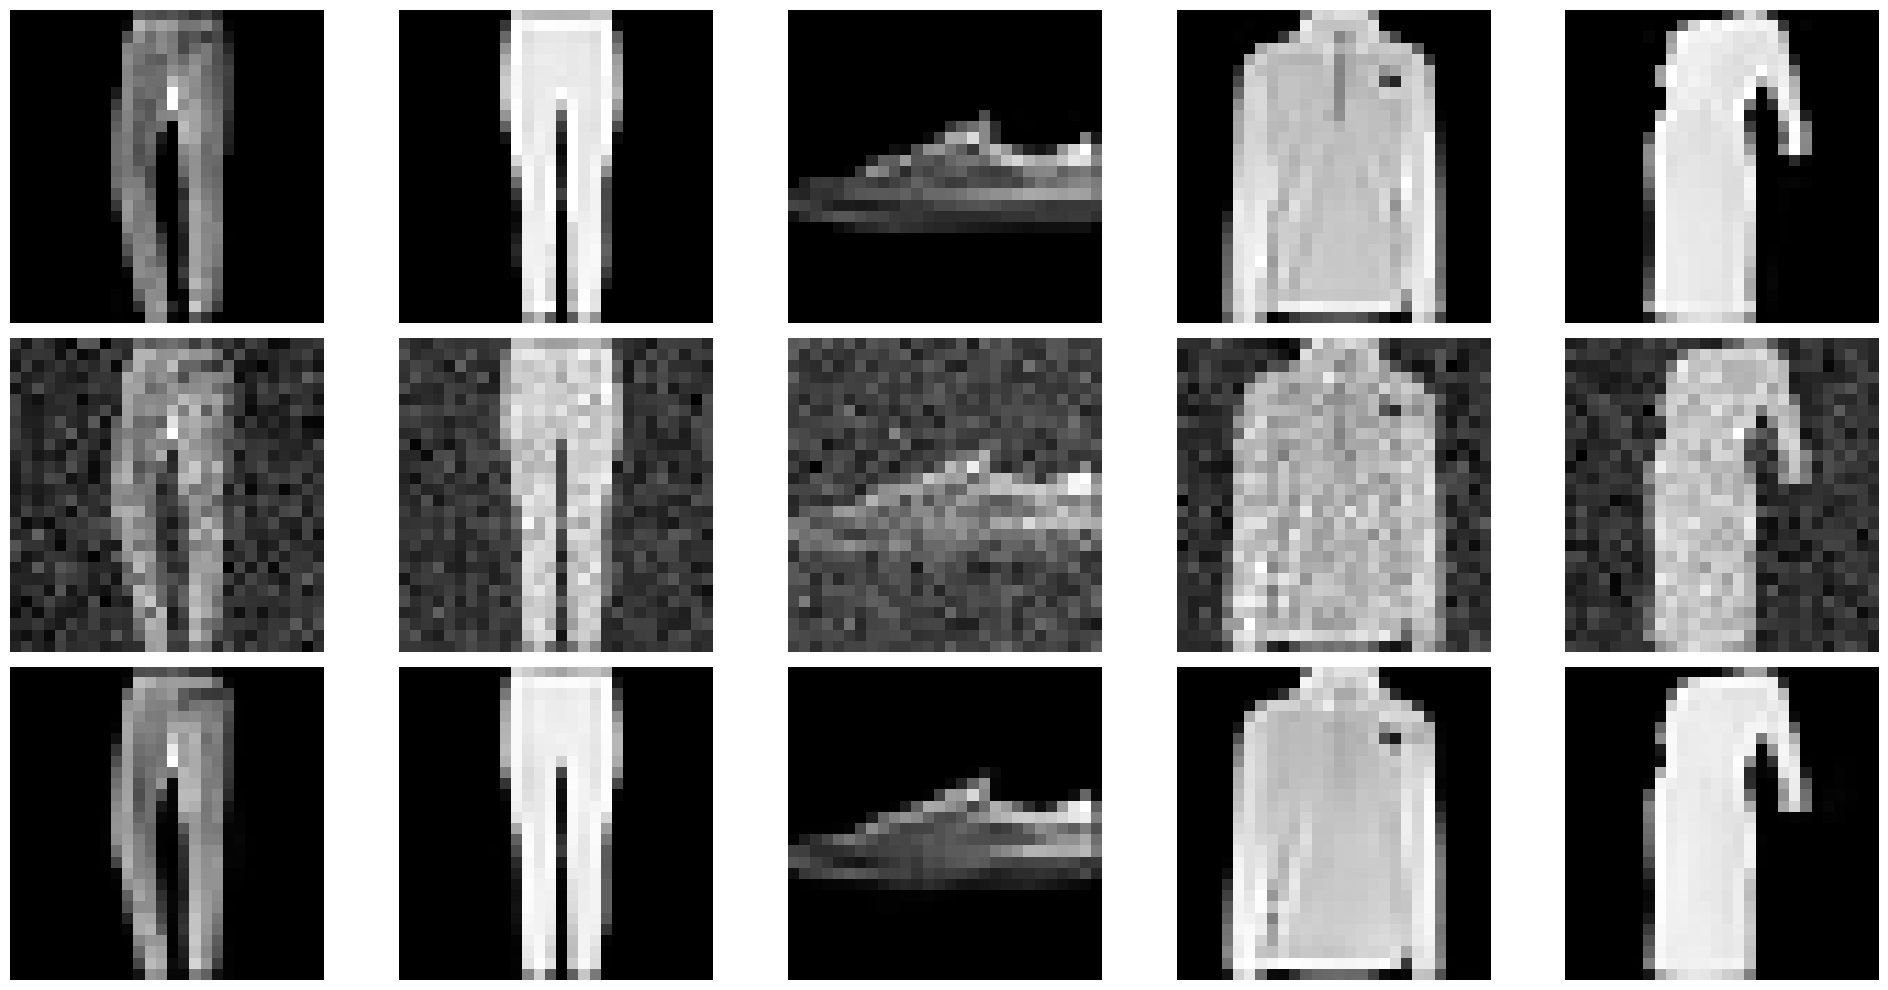

In [136]:
visualize_denoising_examples(amount=5, model=model_denoise_deeper, dataset=train_dataset_noisy)

### Observation
Loss and scores seem to improve! <br>
Improvements are swifter


## Experiment 3: Batch Norm

### For Classification Model

In [150]:
class Net_BatchNorm(nn.Module):
    def __init__(self):
        super(Net_BatchNorm, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.bn2 = nn.BatchNorm2d(64)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [152]:
model_batchnorm = Net_BatchNorm().to(device)
optimizer_batchnorm = torch.optim.Adam(model_batchnorm.parameters(), lr=0.001)
scheduler_batchnorm = torch.optim.lr_scheduler.StepLR(optimizer_batchnorm, step_size=5, gamma=0.1)

for epoch in range(1, 11):
    train(model_batchnorm, device, train_loader_classification, optimizer_batchnorm, loss_fn_classification, epoch)
    test(model_batchnorm, device, test_loader_classification, loss_fn_classification)
    scheduler_batchnorm.step()

Train Epoch: 1 [59520/60000 (99%)]	Loss: 24.329411
Test set: Average loss: 0.3321, Accuracy: 8776/10000 (88%)
Train Epoch: 2 [59520/60000 (99%)]	Loss: 29.890305
Test set: Average loss: 0.2940, Accuracy: 8939/10000 (89%)
Train Epoch: 3 [59520/60000 (99%)]	Loss: 16.817226
Test set: Average loss: 0.2657, Accuracy: 9026/10000 (90%)
Train Epoch: 4 [59520/60000 (99%)]	Loss: 22.555992
Test set: Average loss: 0.2608, Accuracy: 9058/10000 (91%)
Train Epoch: 5 [59520/60000 (99%)]	Loss: 9.7423774
Test set: Average loss: 0.2413, Accuracy: 9143/10000 (91%)
Train Epoch: 6 [59520/60000 (99%)]	Loss: 9.8878859
Test set: Average loss: 0.2249, Accuracy: 9201/10000 (92%)
Train Epoch: 7 [59520/60000 (99%)]	Loss: 9.5724617
Test set: Average loss: 0.2234, Accuracy: 9216/10000 (92%)
Train Epoch: 8 [59520/60000 (99%)]	Loss: 14.664419
Test set: Average loss: 0.2201, Accuracy: 9225/10000 (92%)
Train Epoch: 9 [59520/60000 (99%)]	Loss: 8.6861270
Test set: Average loss: 0.2194, Accuracy: 9228/10000 (92%)
Train Epoc

In [153]:
true_positive = torch.zeros(10)     # TP
true_negative = torch.zeros(10)     # TN
false_positive = torch.zeros(10)    # FP
false_negative = torch.zeros(10)    # FN 

model_batchnorm.eval()
model_batchnorm.to(device)
for data, target in test_dataset:
    data = data.to(device)
    out = model_batchnorm(data.unsqueeze(0))
    pred = out.argmax(dim=1, keepdims= True)
    if pred == target:
        true_positive[target] += 1          # TP
        # True Negatives
        for i in range(10):
            if i != target:
                true_negative[i] += 1       # TN
    else:
        false_negative[target] += 1         # FN
        false_positive[pred.to("cpu")] += 1 # FP

# Accuracy: correct classifications/total classifications   OR  (TP+TN)/(TP+TN+FP+FN) 
accuracy_matrix_batchnorm = (true_positive + true_negative) / (true_positive + true_negative + false_positive + false_negative)

# Precision:  correct actual positives/ everthing classified as positive:  TP/(TP+FP)
precision_matrix_batchnorm = true_positive/(true_positive + false_positive)

# Recall: correct actual positives/ all actual positives : TP/(TP+FN)
recall_matric_batchnorm = true_positive/(true_positive + false_negative)

# F1 Score: 2* (Precision*Recall)/(Precision+Recall)   OR  # 2*TP/(2*TP + FP + FN)
f1_matrix_batchnorm = 2 * true_positive / (2*true_positive + false_positive + false_negative)
f1_matrix_2_batchnorm = 2* (precision_matrix_batchnorm * recall_matric_batchnorm) / (precision_matrix_batchnorm + recall_matric_batchnorm)

for i in range(10):
    print(idx_to_class[i])
    print(f"  Accuracy for: {round(float(accuracy_matrix_batchnorm[i]*100), 2)}%")
    print(f"  Precision for: {round(float(precision_matrix_batchnorm[i]*100), 2)}%")
    print(f"  Recall for: {round(float(recall_matric_batchnorm[i]*100), 2)}%")
    print(f"  F1 Score: {round(float(f1_matrix_batchnorm[i]*100), 2)}%\n")
    # print(f"F1 Score : {f1_matrix_2[i]}%")

T-shirt/top
  Accuracy for: 97.48%
  Precision for: 88.16%
  Recall for: 87.9%
  F1 Score: 88.03%

Trouser
  Accuracy for: 99.74%
  Precision for: 99.39%
  Recall for: 98.2%
  F1 Score: 98.79%

Pullover
  Accuracy for: 97.62%
  Precision for: 88.47%
  Recall for: 89.0%
  F1 Score: 88.73%

Dress
  Accuracy for: 98.35%
  Precision for: 91.96%
  Recall for: 92.6%
  F1 Score: 92.28%

Coat
  Accuracy for: 97.63%
  Precision for: 87.66%
  Recall for: 90.2%
  F1 Score: 88.91%

Sandal
  Accuracy for: 99.71%
  Precision for: 98.89%
  Recall for: 98.4%
  F1 Score: 98.65%

Shirt
  Accuracy for: 95.28%
  Precision for: 78.05%
  Recall for: 75.4%
  F1 Score: 76.7%

Sneaker
  Accuracy for: 99.32%
  Precision for: 95.98%
  Recall for: 97.8%
  F1 Score: 96.88%

Bag
  Accuracy for: 99.67%
  Precision for: 98.31%
  Recall for: 98.6%
  F1 Score: 98.45%

Ankle boot
  Accuracy for: 99.46%
  Precision for: 97.98%
  Recall for: 97.0%
  F1 Score: 97.49%



### For Denoising Model

In [154]:
class DenoisingNet_BatchNorm(nn.Module):
    def __init__(self):
        super(DenoisingNet_BatchNorm, self).__init__()
        # Encoder (Down)
        self.conv1 = nn.Conv2d(1, 32, 3, 1, padding=1)  # Output: [32, 28, 28]
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, 1, padding=1)  # Output: [64, 28, 28]
        self.bn2 = nn.BatchNorm2d(64)

        # Decoder (Up)
        self.deconv1 = nn.ConvTranspose2d(64, 32, 2, stride=2)  # Output: [32, 28, 28]
        self.bn3 = nn.BatchNorm2d(32)
        self.deconv2 = nn.ConvTranspose2d(32, 1, 3, stride=1, padding=1)  # Output: [1, 28, 28]

    def forward(self, x):
        # Encoder
        x = self.conv1(x)
        x = self.bn1(x)
        # print(f"After conv1: {x.shape}")
        x = F.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        # print(f"After conv2: {x.shape}")
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        # print(f"After max_pool2d: {x.shape}")
        # x = self.dropout1(x)

        # Decoder
        x = self.deconv1(x)
        x = self.bn3(x)
        # print(f"After deconv1: {x.shape}")
        x = F.relu(x)
        x = self.deconv2(x)
        # print(f"After deconv2: {x.shape}")
        output = torch.sigmoid(x)  # For pixel values in [0, 1]
        return output

In [ ]:
model_denoise_batchnorm = DenoisingNet_BatchNorm().to(device)
optimizer_batchnorm = torch.optim.Adam(model_denoise_batchnorm.parameters(), lr=0.001)

for epoch in range(1, 11):
    train(model_denoise_batchnorm, device, train_loader_denoise, optimizer_batchnorm, loss_fn_denoise, epoch)
    print("\n")
    # test(model_denoise, device, test_loader_denoise, loss_fn)

Train Epoch: 1 [59520/60000 (99%)]	Loss: 158.162811

Train Epoch: 2 [59520/60000 (99%)]	Loss: 160.714325

Train Epoch: 3 [59520/60000 (99%)]	Loss: 142.066772

Train Epoch: 4 [59520/60000 (99%)]	Loss: 129.906616

Train Epoch: 5 [59520/60000 (99%)]	Loss: 129.773499

Train Epoch: 6 [59520/60000 (99%)]	Loss: 119.892525

Train Epoch: 7 [59520/60000 (99%)]	Loss: 111.057991

Train Epoch: 8 [59520/60000 (99%)]	Loss: 107.239136

Train Epoch: 9 [59520/60000 (99%)]	Loss: 117.764320

Train Epoch: 10 [59520/60000 (99%)]	Loss: 102.290588



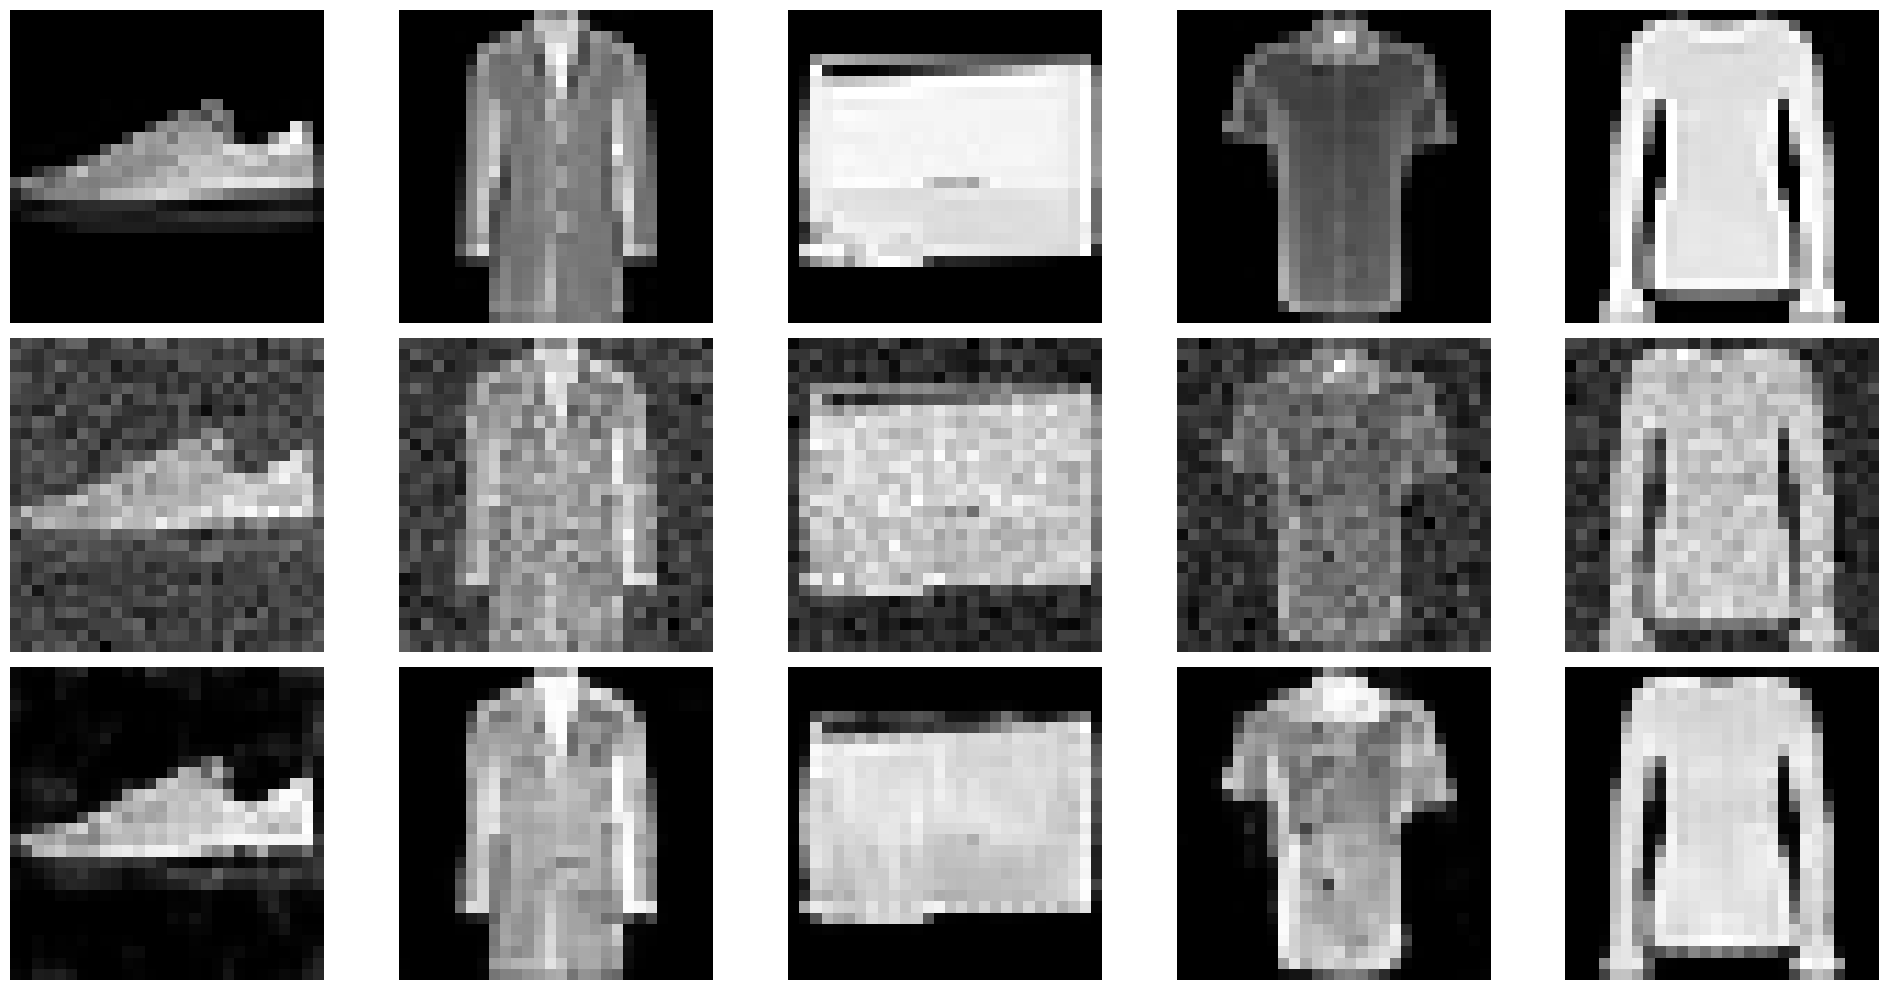

In [ ]:
visualize_denoising_examples(amount=5, model=model_denoise_batchnorm, dataset=train_dataset_noisy)

### Observation

Moderate improvements in results

## Summary

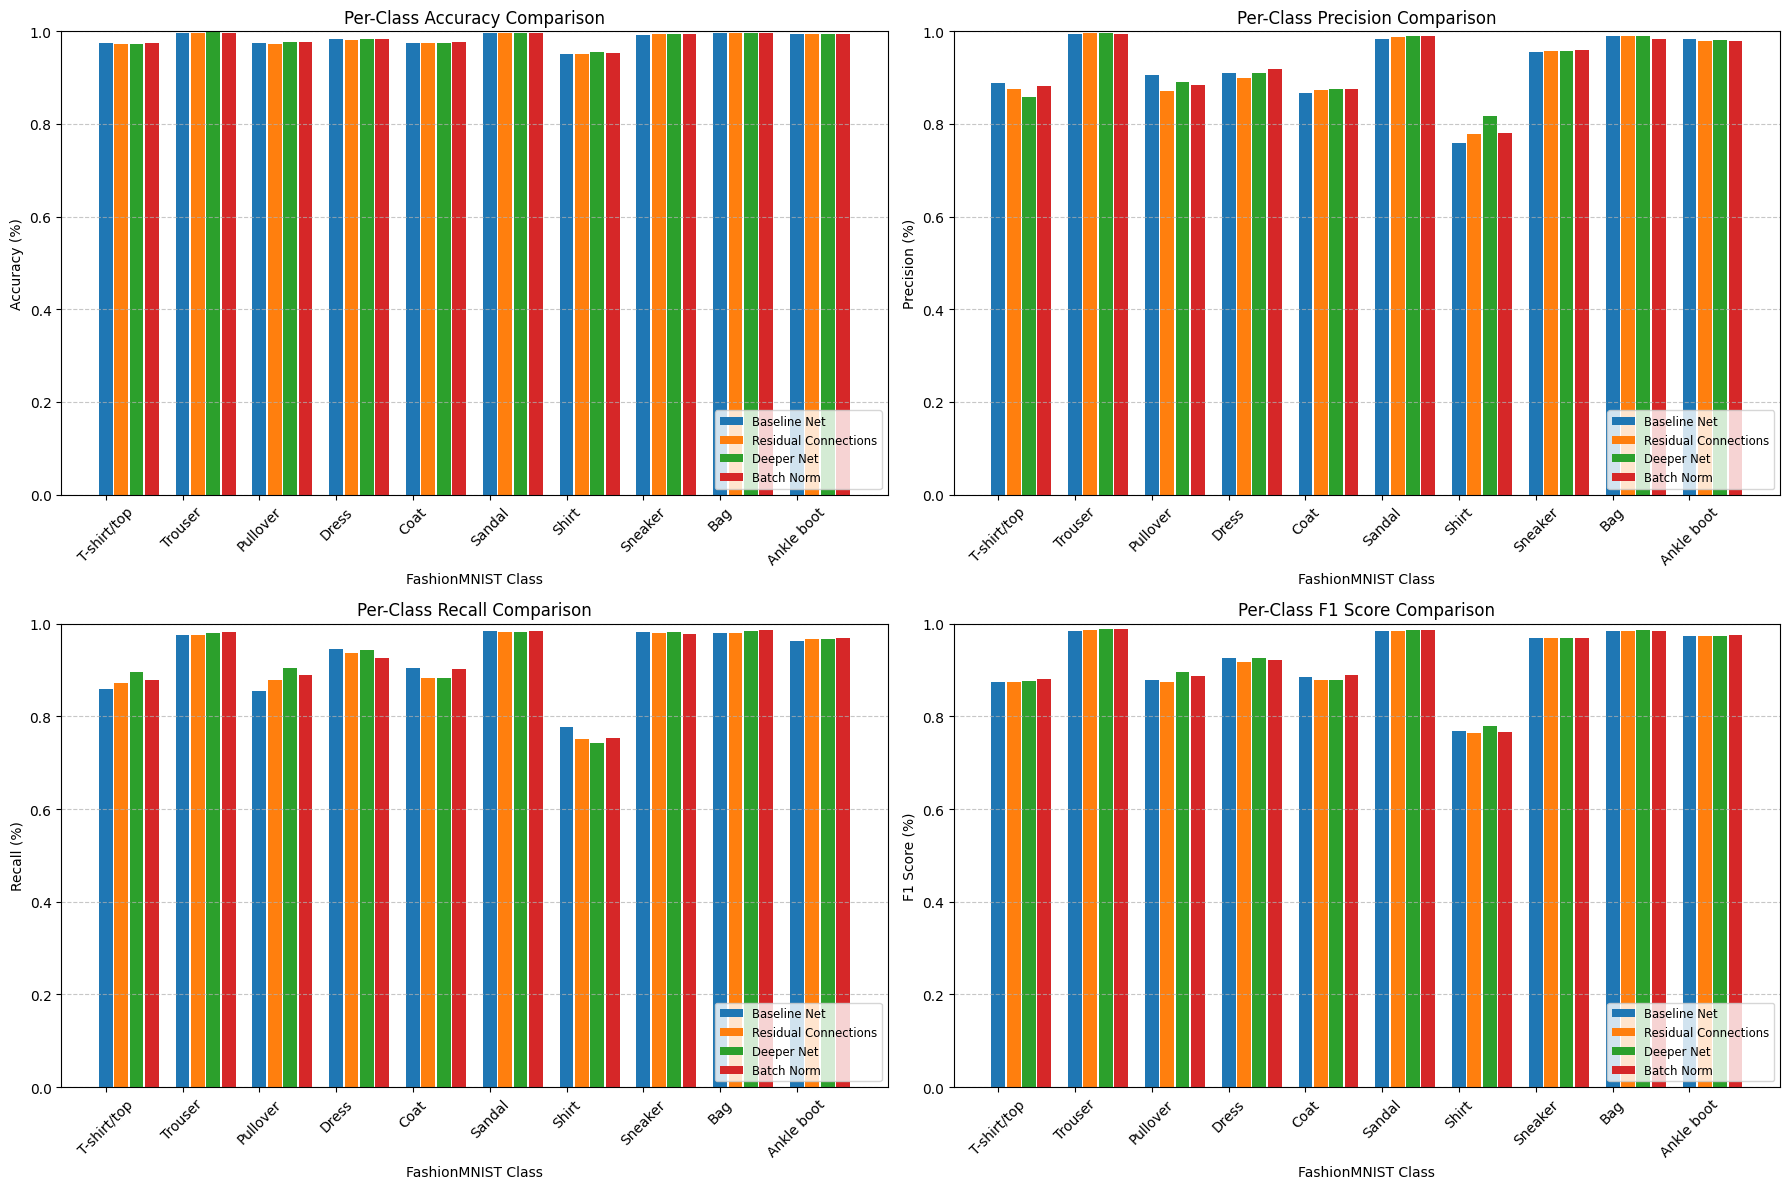

In [159]:
metrics_data = {
    "Accuracy": {
        "Baseline Net": accuracy_matrix,
        "Residual Connections": accuracy_matrix_skipconn,
        "Deeper Net": accuracy_matrix_deeper,
        "Batch Norm": accuracy_matrix_batchnorm,
    },
    "Precision": {
        "Baseline Net": precision_matrix,
        "Residual Connections": precision_matrix_skipconn,
        "Deeper Net": precision_matrix_deeper,
        "Batch Norm": precision_matrix_batchnorm,
    },
    "Recall": {
        "Baseline Net": recall_matric,
        "Residual Connections": recall_matric_skipconn,
        "Deeper Net": recall_matric_deeper,
        "Batch Norm": recall_matric_batchnorm,
    },
    "F1 Score": {
        "Baseline Net": f1_matrix,
        "Residual Connections": f1_matrix_skipconn,
        "Deeper Net": f1_matrix_deeper,
        "Batch Norm": f1_matrix_batchnorm,
    },
}
num_classes = 10
bar_width = 0.18
spacing = 0.02
index = np.arange(num_classes)

plt.figure(figsize=(18, 12)) 

for i, (metric_name, models_data) in enumerate(metrics_data.items()):
    plt.subplot(2, 2, i + 1) 
    
    model_offset = 0
    for model_name, values in models_data.items():
        plt.bar(index + model_offset, values, bar_width, label=model_name)
        model_offset += bar_width + spacing

    plt.xlabel("FashionMNIST Class")
    plt.ylabel(f"{metric_name} (%)")
    plt.title(f"Per-Class {metric_name} Comparison")
    plt.xticks(range(10), [idx_to_class[i] for i in range(10)], rotation=45)
    plt.ylim(0, 1) 
    plt.legend(loc='lower right', fontsize='small')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [160]:
def visualize_denoising_summary_compare(amount, models_dict, dataset=None):
    indices = random.sample(range(len(dataset)), amount)

    noisy_images, original_images = zip(*[dataset[idx] for idx in indices])
    
    # Total rows
    total_rows = 2 + len(models_dict)
    
    plt.figure(figsize=(20, total_rows * 3)) # Adjust figure height based on number of models

    # Plot Original images (Row 1)
    for i in range(amount):
        plt.subplot(total_rows, amount, i + 1)
        plt.imshow(original_images[i].squeeze().cpu().numpy(), cmap="gray")
        plt.axis("off")
        if i == 0:
            plt.ylabel("Original", fontsize=14)

    # Plot Noisy images (Row 2)
    for i in range(amount):
        plt.subplot(total_rows, amount, amount + i + 1)
        plt.imshow(noisy_images[i].squeeze().cpu().numpy(), cmap="gray")
        plt.axis("off")
        if i == 0:
            plt.ylabel("Noisy", fontsize=14)

    # Plot Denoised images for each model
    row_offset = 2 * amount
    with torch.no_grad():
        for model_name, model in models_dict.items():
            model.eval()

            denoised_images_model = [model(noisy_img.unsqueeze(0).to(device)).squeeze().cpu().numpy() for noisy_img in noisy_images]

            for i in range(amount):
                plt.subplot(total_rows, amount, row_offset + i + 1)
                plt.imshow(denoised_images_model[i], cmap="gray")
                plt.axis("off")
                if i == 0:
                    plt.ylabel(f"Denoised by {model_name}", fontsize=14)
            
            row_offset += amount # Move to the next row for the next model

    plt.tight_layout()
    plt.show()

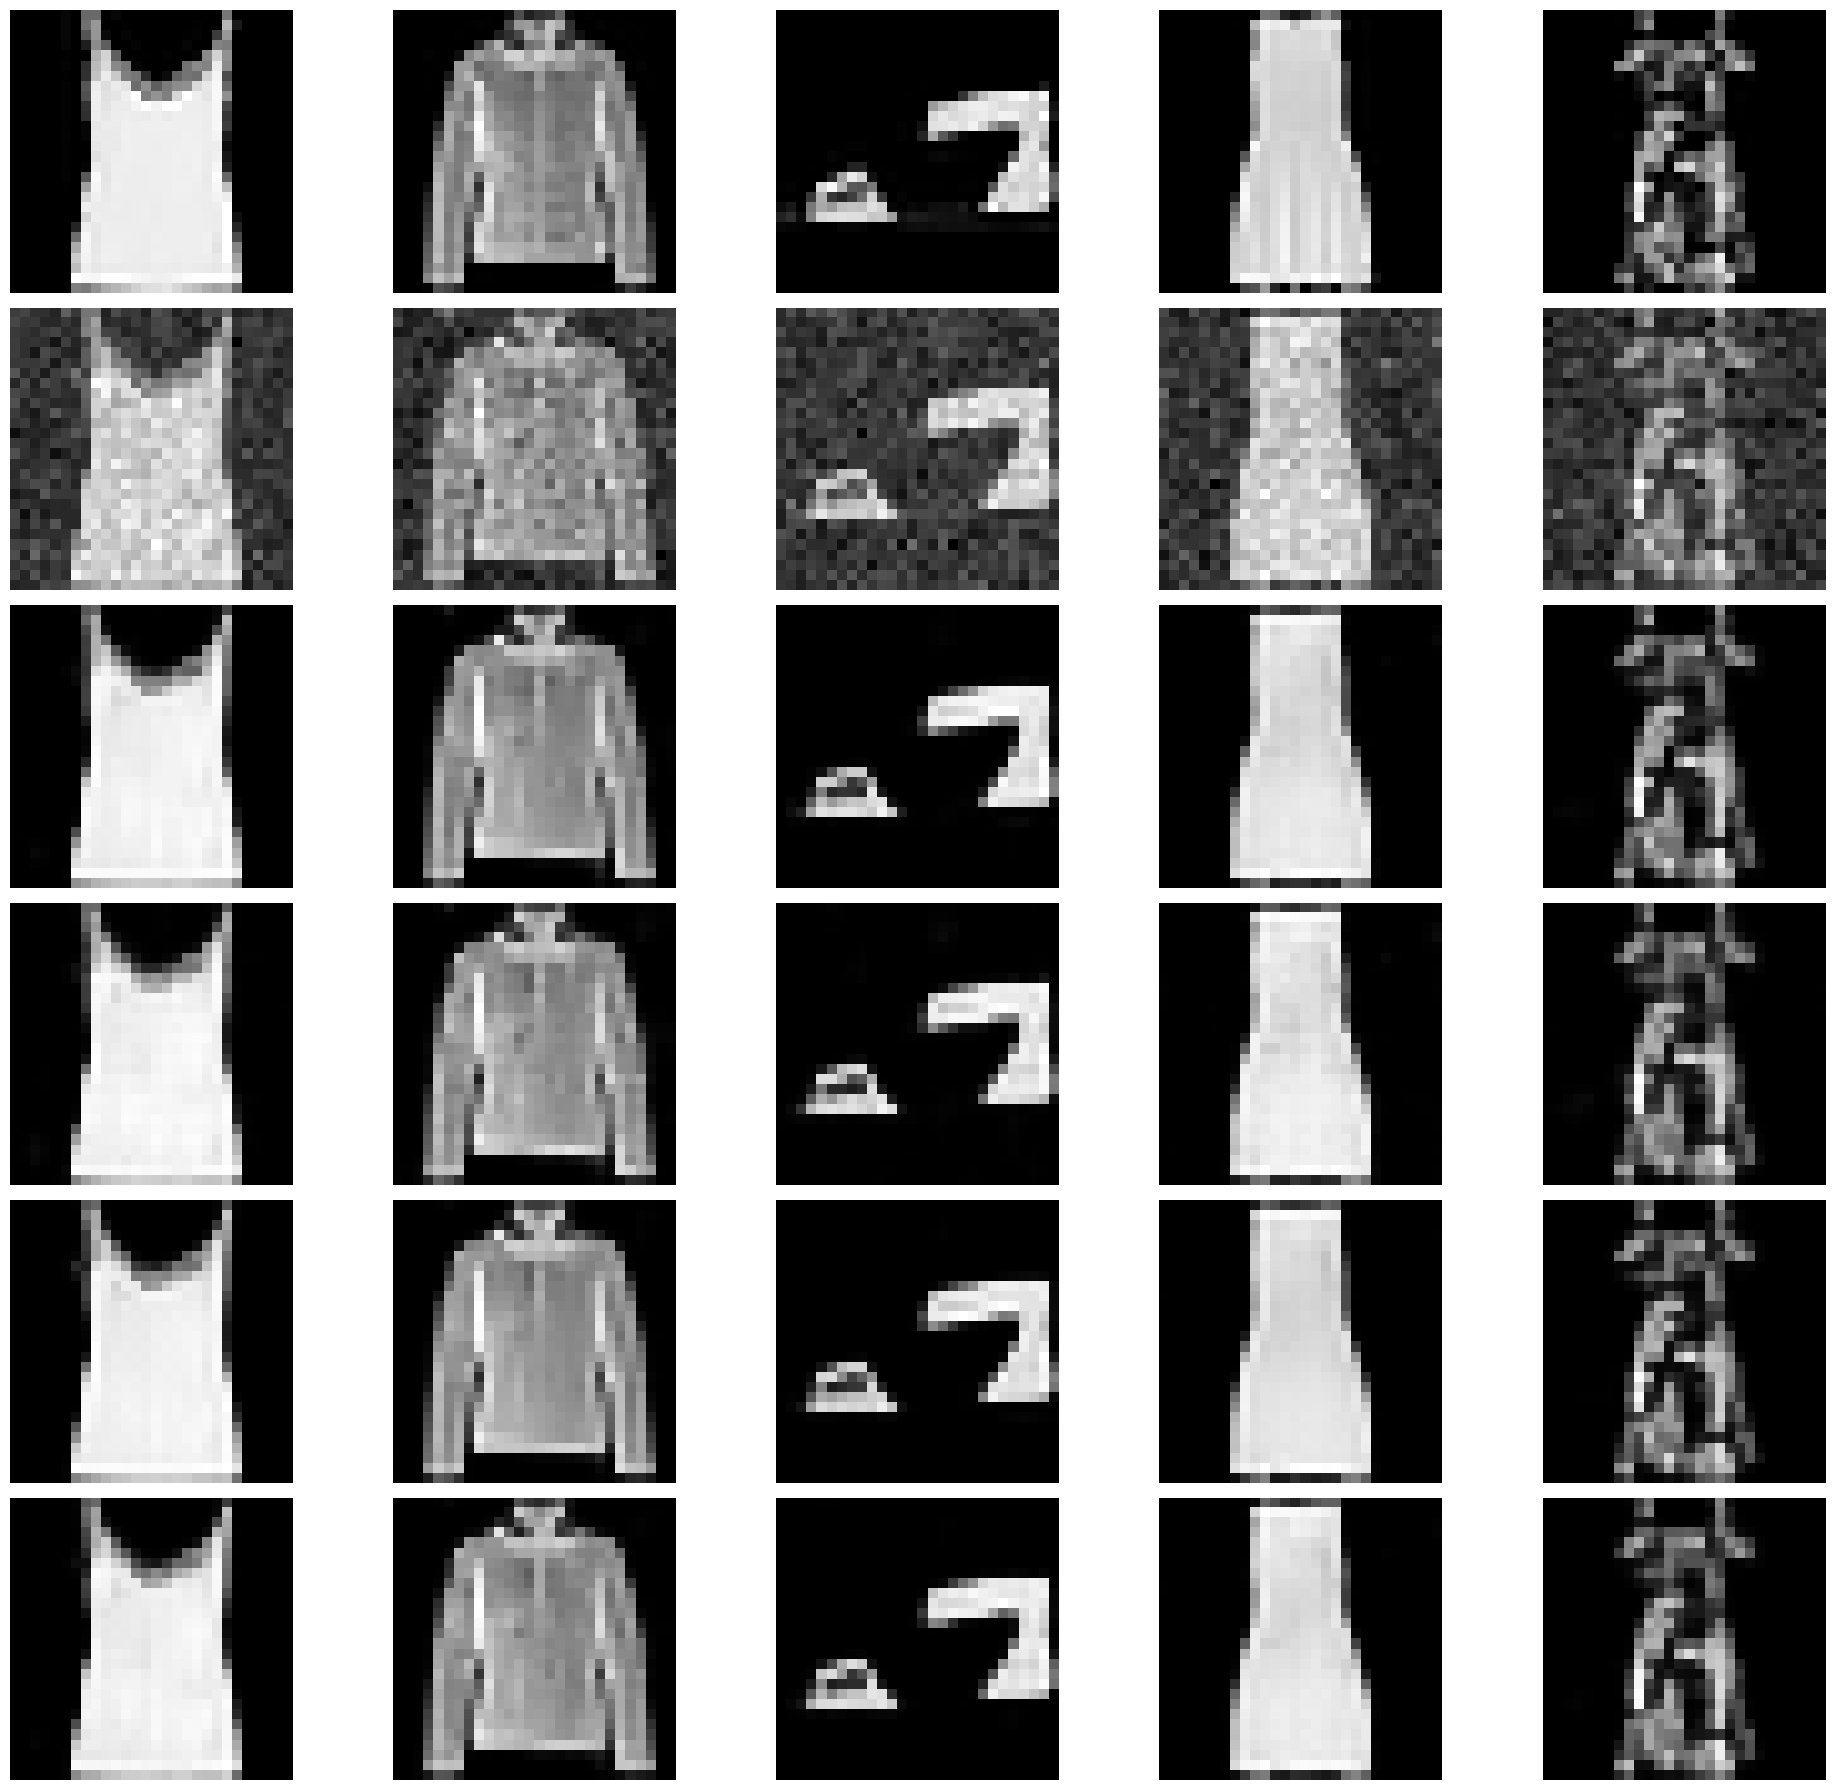

In [161]:
models_to_compare = {
    "Baseline": model_denoise,
    "Residual Connections": model_denoise_skipcon,
    "Deeper Net": model_denoise_deeper,
    "Batch Norm": model_denoise_batchnorm,
}

visualize_denoising_summary_compare(amount=5, models_dict=models_to_compare, dataset=train_dataset_noisy)